In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

sns.set()
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'



#  Predicting heart diseases

**Goal:** Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

**Data description**

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.


In [ ]:
!wget https://raw.githubusercontent.com/yexf308/PracticalML/main/data/mlbootcamp5_train.csv?raw=true -O mlbootcamp5_train.csv


--2024-03-08 23:26:50--  https://raw.githubusercontent.com/yexf308/PracticalML/main/data/mlbootcamp5_train.csv?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2941524 (2.8M) [text/plain]
Saving to: ‘mlbootcamp5_train.csv’

mlbootcamp5_train.c 100%[===================>]   2.80M  --.-KB/s    in 0.05s   

2024-03-08 23:26:51 (59.5 MB/s) - ‘mlbootcamp5_train.csv’ saved [2941524/2941524]



In [ ]:
df = pd.read_csv('mlbootcamp5_train.csv',index_col="id", sep=";")

In [ ]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0




---


##  Transform the features
It is important to preprocessing your data.

- create "age in years" dividing age by 365.25 and taking floor ($\lfloor{x}\rfloor$ is the largest integer that is less than or equal to $x$)
- create 3 binary features based on `cholesterol`.
- create 3 binary features based on `gluc`.
<br> Binary features equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummies`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

- Split data into train and holdout parts in the proportion of 70/30 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [ ]:
df['age'] = np.floor(df['age'] / 365.25)

In [ ]:
df1 = df

In [ ]:
cholesterol_dummies = pd.get_dummies(df['cholesterol'], prefix='cholesterol')
df = pd.concat([df, cholesterol_dummies], axis=1)
df.drop('cholesterol', axis=1, inplace=True)

glucose_dummies = pd.get_dummies(df['gluc'], prefix='gluc')
df = pd.concat([df, glucose_dummies], axis=1)
df.drop('gluc', axis=1, inplace=True)

In [ ]:
X = df.drop(columns=['cardio'])
y = df['cardio']

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

In [ ]:
print("Training data shape:", X_train.shape, y_train.shape)
print("Holdout data shape:", X_holdout.shape, y_holdout.shape)

Training data shape: (49000, 15) (49000,)
Holdout data shape: (21000, 15) (21000,)




---


##  First Try: Decision Tree
- Train a decision tree on the dataset `(X_train, y_train)` with **max depth equal to 3** and `random_state=17`.

- Plot this tree with `sklearn.tree.export_graphviz` and Graphviz.  

- Which 3 features are used to make predictions in the created decision tree?

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

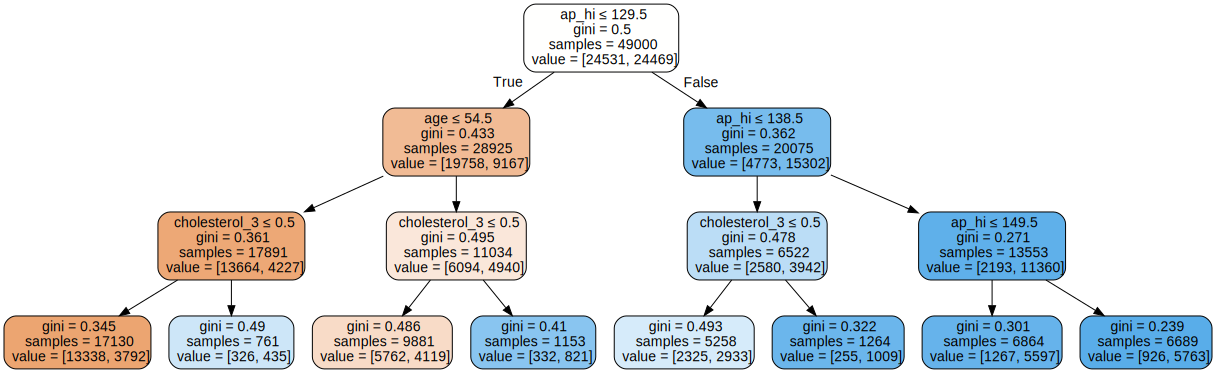

In [ ]:
dot_data = export_graphviz(decision_tree, out_file=None, feature_names=X_train.columns, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
#Verifying using feature importance

feature_importances = decision_tree.feature_importances_
top_3_indices = feature_importances.argsort()[-3:][::-1]
top_3_features = X_train.columns[top_3_indices]
print("Top 3 features that are used to make predictions from the above decision tree are:", top_3_features)

Top 3 features that are used to make predictions from the above decision tree are: Index(['ap_hi', 'age', 'cholesterol_3'], dtype='object')


### **Discuss your findings**:

As we can see from the above decison tree it is evident that the features that are used to make predictions from the above decision tree are:

1.   ap_hi
2.   age
3.   cholestrol_3



---


##  Second Try: Cross-Validation
- Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

- Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

- Print the best value of `max_depth` where the mean value of cross-validation quality metric reaches maximum. Also compute accuracy on holdout data. This can be done with the trained instance of the class `GridSearchCV`.

- Сalculate the effect of `GridSearchCV`: check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning max_depth with GridSearchCV respectively.

In [ ]:
parameters_grid = {'max_depth': range(2, 11)}
grid_search = GridSearchCV(decision_tree, parameters_grid, cv=5)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']
print("Best max_depth:", best_max_depth)

Best max_depth: 6


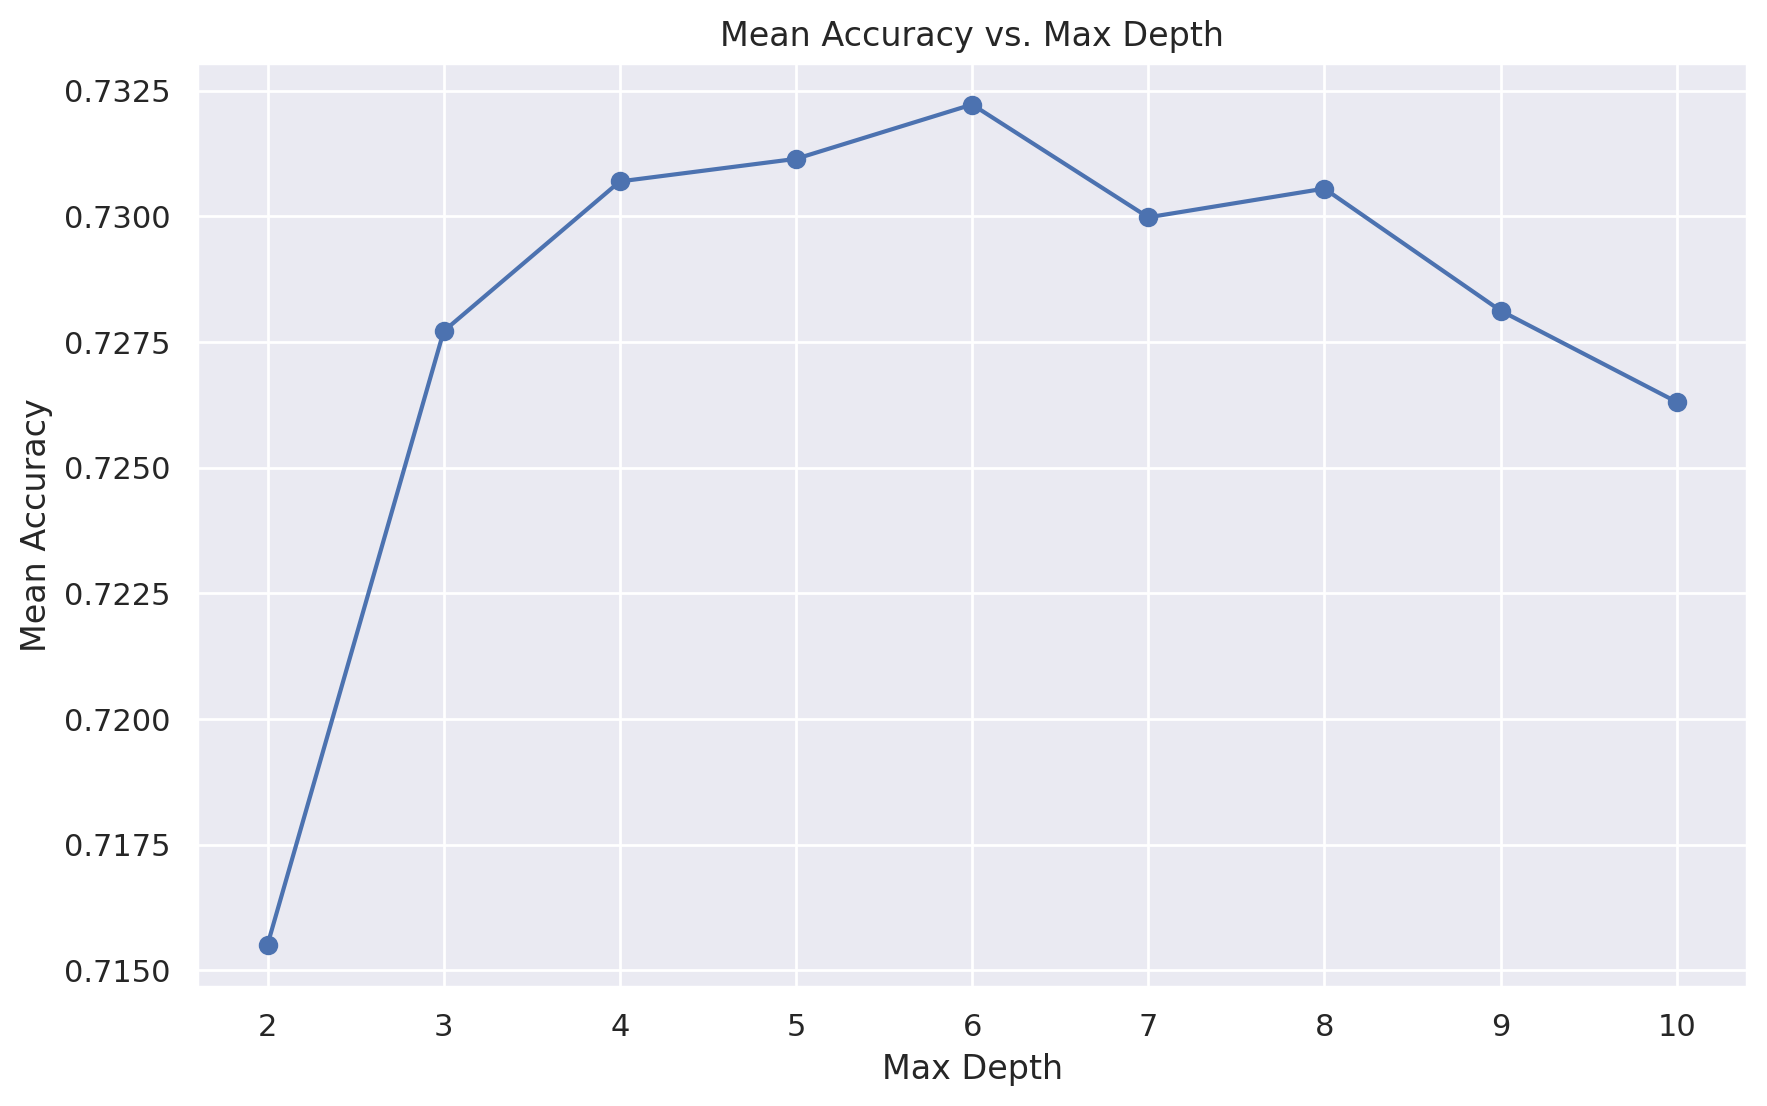

In [ ]:
mean_accuracy_scores = grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), mean_accuracy_scores, marker='o')
plt.title('Mean Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

In [ ]:
print("Best value of max_depth is :", best_max_depth)
accuracy_holdout = grid_search.score(X_holdout, y_holdout)
print("Accuracy on holdout data:", accuracy_holdout)

Best value of max_depth is : 6
Accuracy on holdout data: 0.7256666666666667


In [ ]:
acc_before_tuning = decision_tree.score(X_holdout, y_holdout)
print("Accuracy on holdout data before tuning:", acc_before_tuning)
print("Accuracy on holdout data after tuning:", accuracy_holdout)
acc_after_tuning = accuracy_holdout
effect = (acc_after_tuning - acc_before_tuning) / acc_before_tuning * 100
print("Effect of GridSearchCV: {:.2f}%".format(effect))

Accuracy on holdout data before tuning: 0.7212857142857143
Accuracy on holdout data after tuning: 0.7256666666666667
Effect of GridSearchCV: 0.61%


### **Discuss your findings**:

 Based on our results we can come to an understanding that the best max depth for our decison tree classifier after the hyperparameter tuning is 6.

After the max depth 6 it looks like the classifier is overfitting as the mean accuracy score is decreasing.

When we compare both accuracies before and after tuning there isn't so much of differnt but as u can see there is 0.61% on the model with the best parameter after cross validation and grid search.



---


##  Final Try: Feature Engineering
From the SCORE table to estimate ten-year risk of fatal cardiovascular disease in Europe. The source paper is [here](https://academic.oup.com/eurheartj/article/24/11/987/427645).

Create a sub dataframe with the following features:
-  ``smoke`` feature.

- Build the ``cholesterol``  and ``gender`` features. Transform the ``cholesterol`` to 3 binary features according to it's 3 unique values ( ``cholesterol``=1,  ``cholesterol``=2 and  ``cholesterol``=3). Transform the ``gender`` from 1 and 2 into 0 and 1. It is better to rename it to ``male`` (0 – woman, 1 – man). In general, this is typically done with ``sklearn.preprocessing.LabelEncoder`` but here in case of only 2 unique values it's not necessary.

- **New feature**, Age in year: age $\in [40,50)$, age $\in [50,55)$, age $\in [55,60)$, age $\in [60,65) $ (4 features)
- **New feature**, systolic blood pressure: ap\_hi $\in [120,140)$, ap\_hi $\in [140,160)$, ap\_hi $\in [160,180),$ (3 features)


If the values of age or blood pressure don't fall into any of the intervals then all binary features will be equal to zero.

Finally, the decision tree is built using these 12 binary features (excluding all original features that we had before this feature engineering part).

- Create a decision tree with the limitation `max_depth=3` and train it on the whole train data. Use the `DecisionTreeClassifier` class with fixed `random_state=17`, but all other arguments (except for `max_depth` and `random_state`) should be left with their default values.

- Which binary feature is the most important for heart disease detection?

- After feature engineering, does accuracy on holdout data improve?




In [ ]:
sub_data = df1[['smoke','cholesterol','gender','age','ap_hi','cardio']]

In [ ]:
cholesterol_dummies = pd.get_dummies(sub_data['cholesterol'], prefix='cholesterol')
sub_data = pd.concat([sub_data, cholesterol_dummies], axis=1)
sub_data.drop('cholesterol', axis=1, inplace=True)

In [ ]:
sub_data['gender'] = sub_data['gender'].apply(lambda x: 1 if x == 2 else 0)
sub_data.rename(columns={'gender': 'male'}, inplace=True)

In [ ]:
sub_data['age_in_year'] = pd.cut(sub_data['age'], bins=[40, 50, 55, 60, 65], labels=['40-49', '50-54', '55-59', '60-64'])
age_dummies = pd.get_dummies(sub_data['age_in_year'], prefix='age')
sub_data = pd.concat([sub_data, age_dummies], axis=1)
sub_data.drop(['age', 'age_in_year'], axis=1, inplace=True)
sub_data['systolic_blood_pressure'] = pd.cut(sub_data['ap_hi'], bins=[120, 140, 160, 180], labels=['120-139', '140-159', '160-179'])
ap_hi_dummies = pd.get_dummies(sub_data['systolic_blood_pressure'], prefix='ap_hi')
sub_data = pd.concat([sub_data, ap_hi_dummies], axis=1)
sub_data.drop(['ap_hi', 'systolic_blood_pressure'], axis=1, inplace=True)

In [ ]:
sub_data.columns

Index(['smoke', 'male', 'cardio', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3', 'age_40-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'ap_hi_120-139', 'ap_hi_140-159', 'ap_hi_160-179'],
      dtype='object')

In [ ]:
X = sub_data.drop(columns=['cardio'])
y = sub_data['cardio']

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)
print("Training data shape:", X_train.shape, y_train.shape)
print("Holdout data shape:", X_holdout.shape, y_holdout.shape)

Training data shape: (49000, 12) (49000,)
Holdout data shape: (21000, 12) (21000,)


In [ ]:
decision_treen = DecisionTreeClassifier(max_depth=3, random_state=17)
decision_treen.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

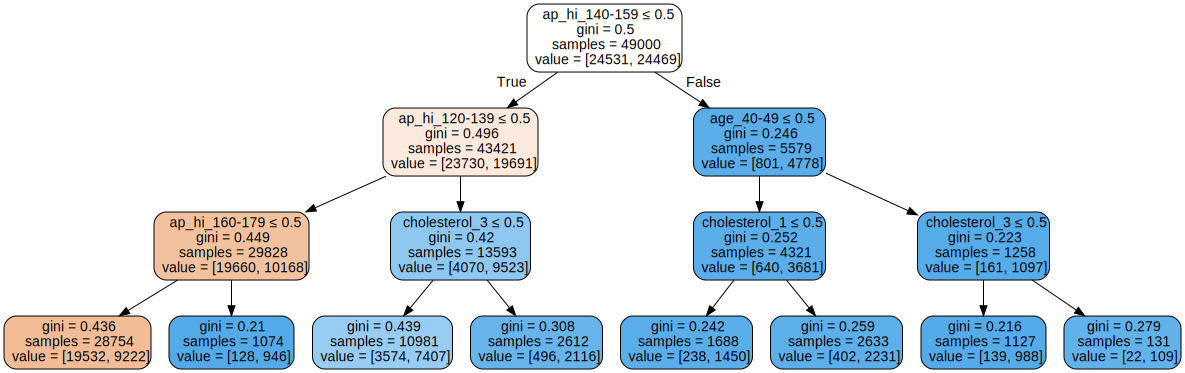

In [ ]:
dot_data = export_graphviz(decision_treen, out_file=None, feature_names=X_train.columns, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

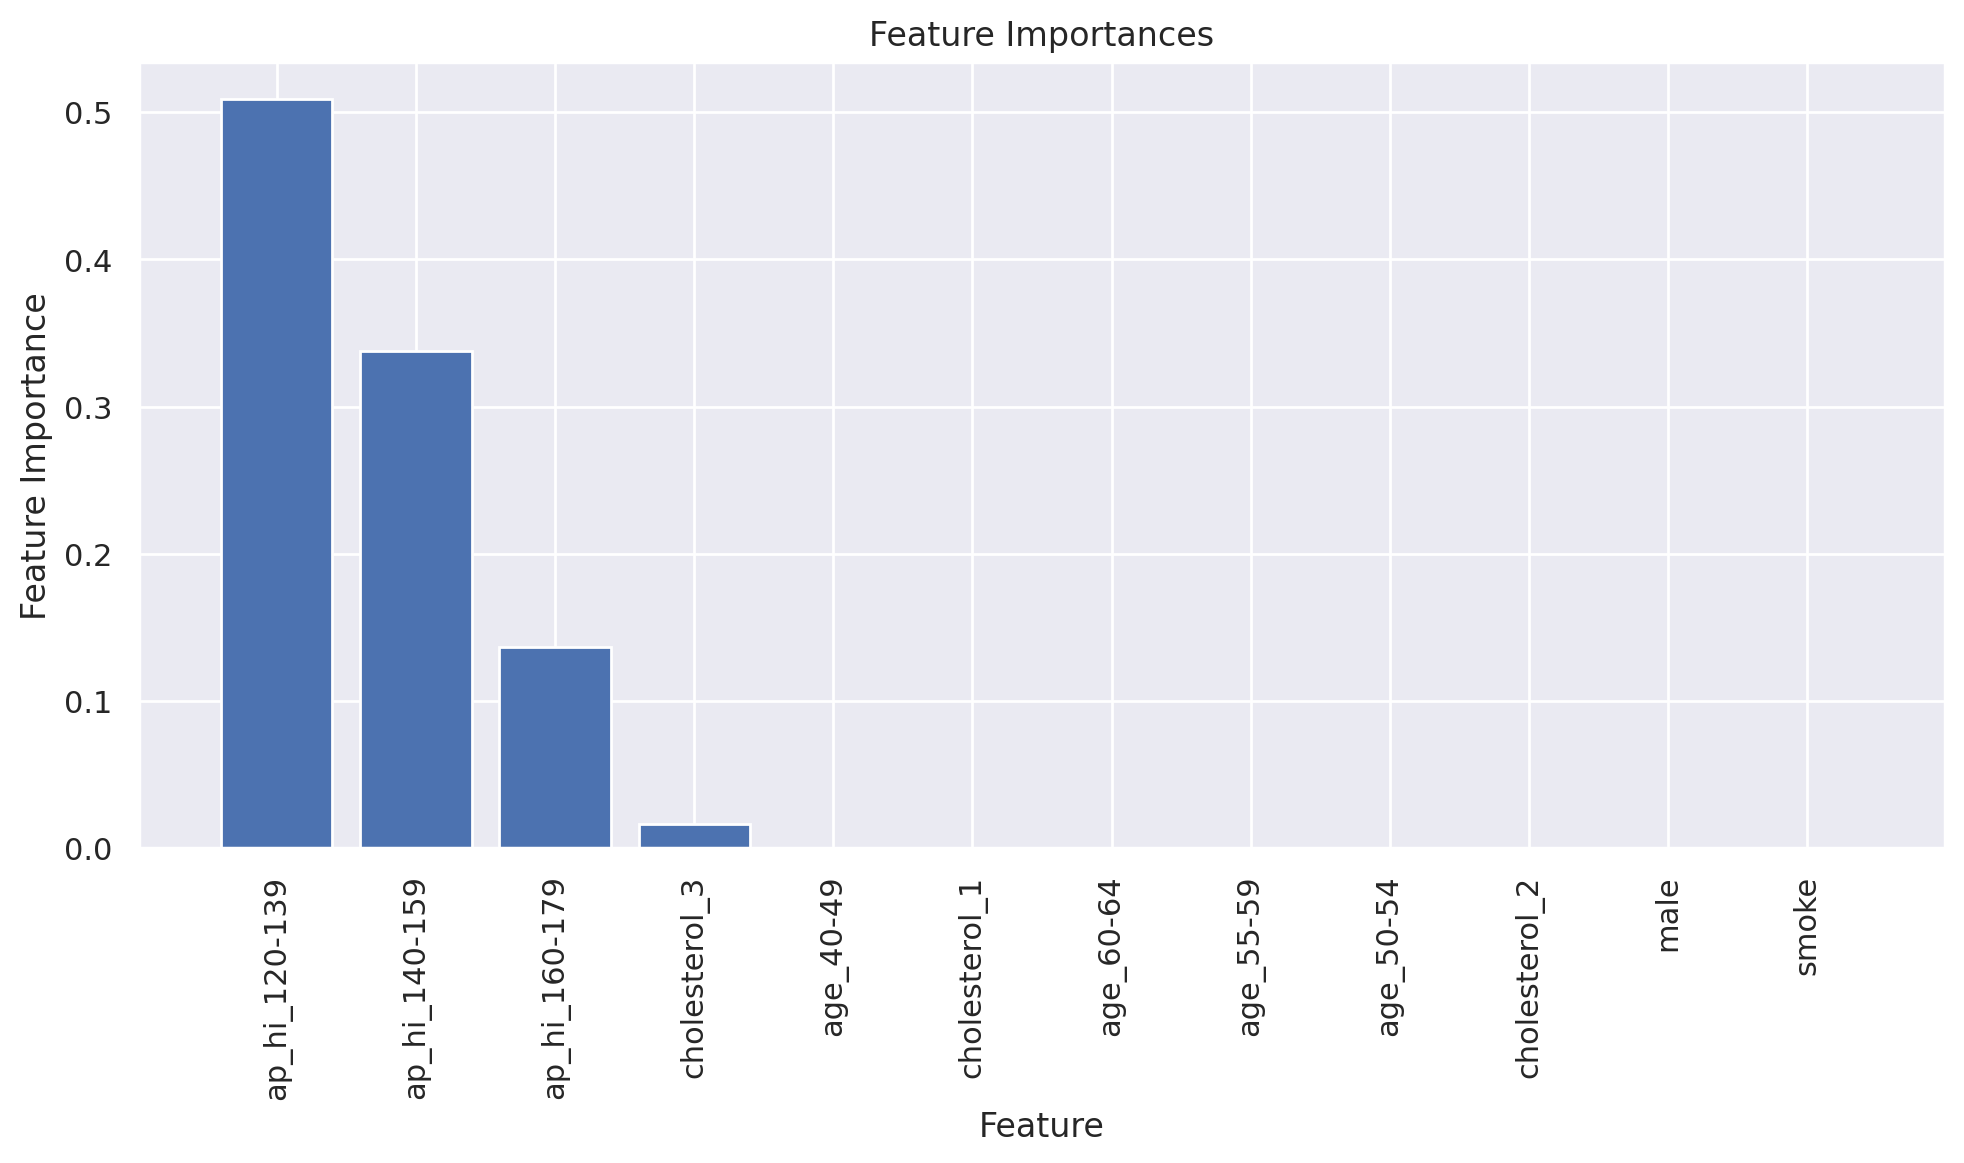

In [ ]:
importances = decision_treen.feature_importances_
indices = importances.argsort()[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
accuracy = decision_treen.score(X_holdout, y_holdout)

In [ ]:
accuracy

0.7043809523809523

As per the looks of the code we can say that

ap_hi_120-139 is the most important fetaure
and No, after this feature engineering the accuarcy did not get better

In [ ]:
df2 = df1

In [ ]:
# Calculating BMI(Body Mass Index) instead of relying on weight and height individually I believe having an interaction term could be a better predictor

df2['height_m'] = df2['height'] / 100  #Converting height to meters
df2['BMI'] = df2['weight'] / (df2['height_m'] ** 2)

In [ ]:
df2['gender'] = df2['gender'].apply(lambda x: 1 if x == 2 else 0)
df2.rename(columns={'gender': 'male'}, inplace=True)

In [ ]:
df2

,age,male,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,height_m,BMI
id,,,,,,,,,,,,,,
0,50.0,1,168,62.0,110,80,1,1,0,0,1,0,1.68,21.967120
1,55.0,0,156,85.0,140,90,3,1,0,0,1,1,1.56,34.927679
2,51.0,0,165,64.0,130,70,3,1,0,0,0,1,1.65,23.507805
3,48.0,1,169,82.0,150,100,1,1,0,0,1,1,1.69,28.710479
4,47.0,0,156,56.0,100,60,1,1,0,0,0,0,1.56,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,52.0,1,168,76.0,120,80,1,1,1,0,1,0,1.68,26.927438
99995,61.0,0,158,126.0,140,90,2,2,0,0,1,1,1.58,50.472681
99996,52.0,1,183,105.0,180,90,3,1,0,1,0,1,1.83,31.353579


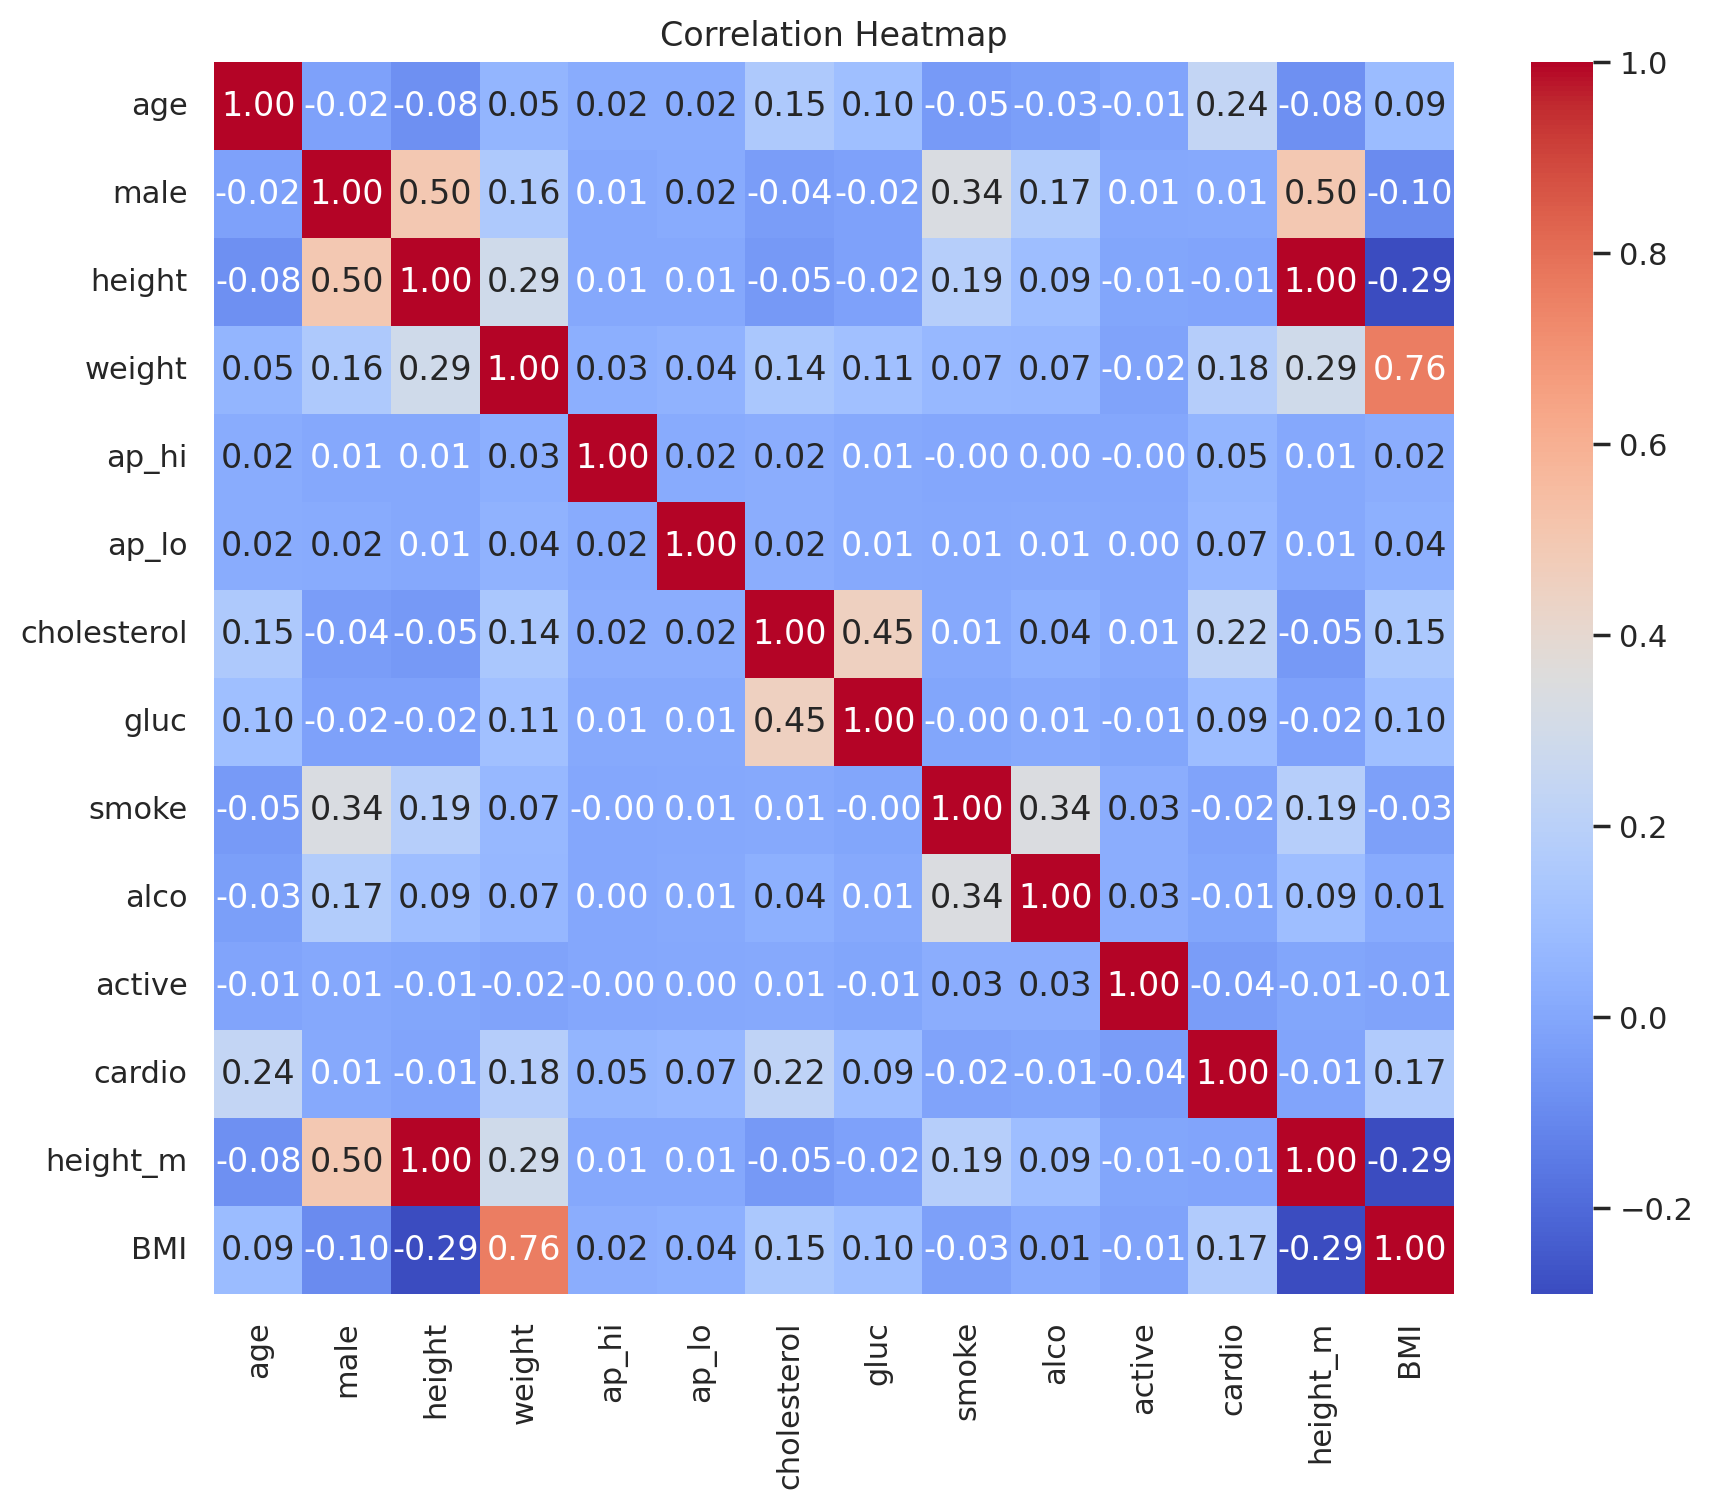

In [ ]:
corr = df2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

As we can see cholestrol is somewhat highly correlated to glucose levels than other features do individually so i believe having binary features for them is more helpful

In [ ]:
cholesterol_dummies = pd.get_dummies(df2['cholesterol'], prefix='cholesterol')
df2 = pd.concat([df2, cholesterol_dummies], axis=1)
#sub_data.drop('cholesterol', axis=1, inplace=True)

In [ ]:
df2['glucose_cholesterol_1_interaction'] = df2['gluc'] * df2['cholesterol_1']
df2['glucose_cholesterol_2_interaction'] = df2['gluc'] * df2['cholesterol_2']
df2['glucose_cholesterol_3_interaction'] = df2['gluc'] * df2['cholesterol_3']
df2['bmi_physical_activity_interaction'] = df2['BMI'] * df2['active']

df2['alco_smoke_interaction'] = df2['alco'] * df2['smoke']


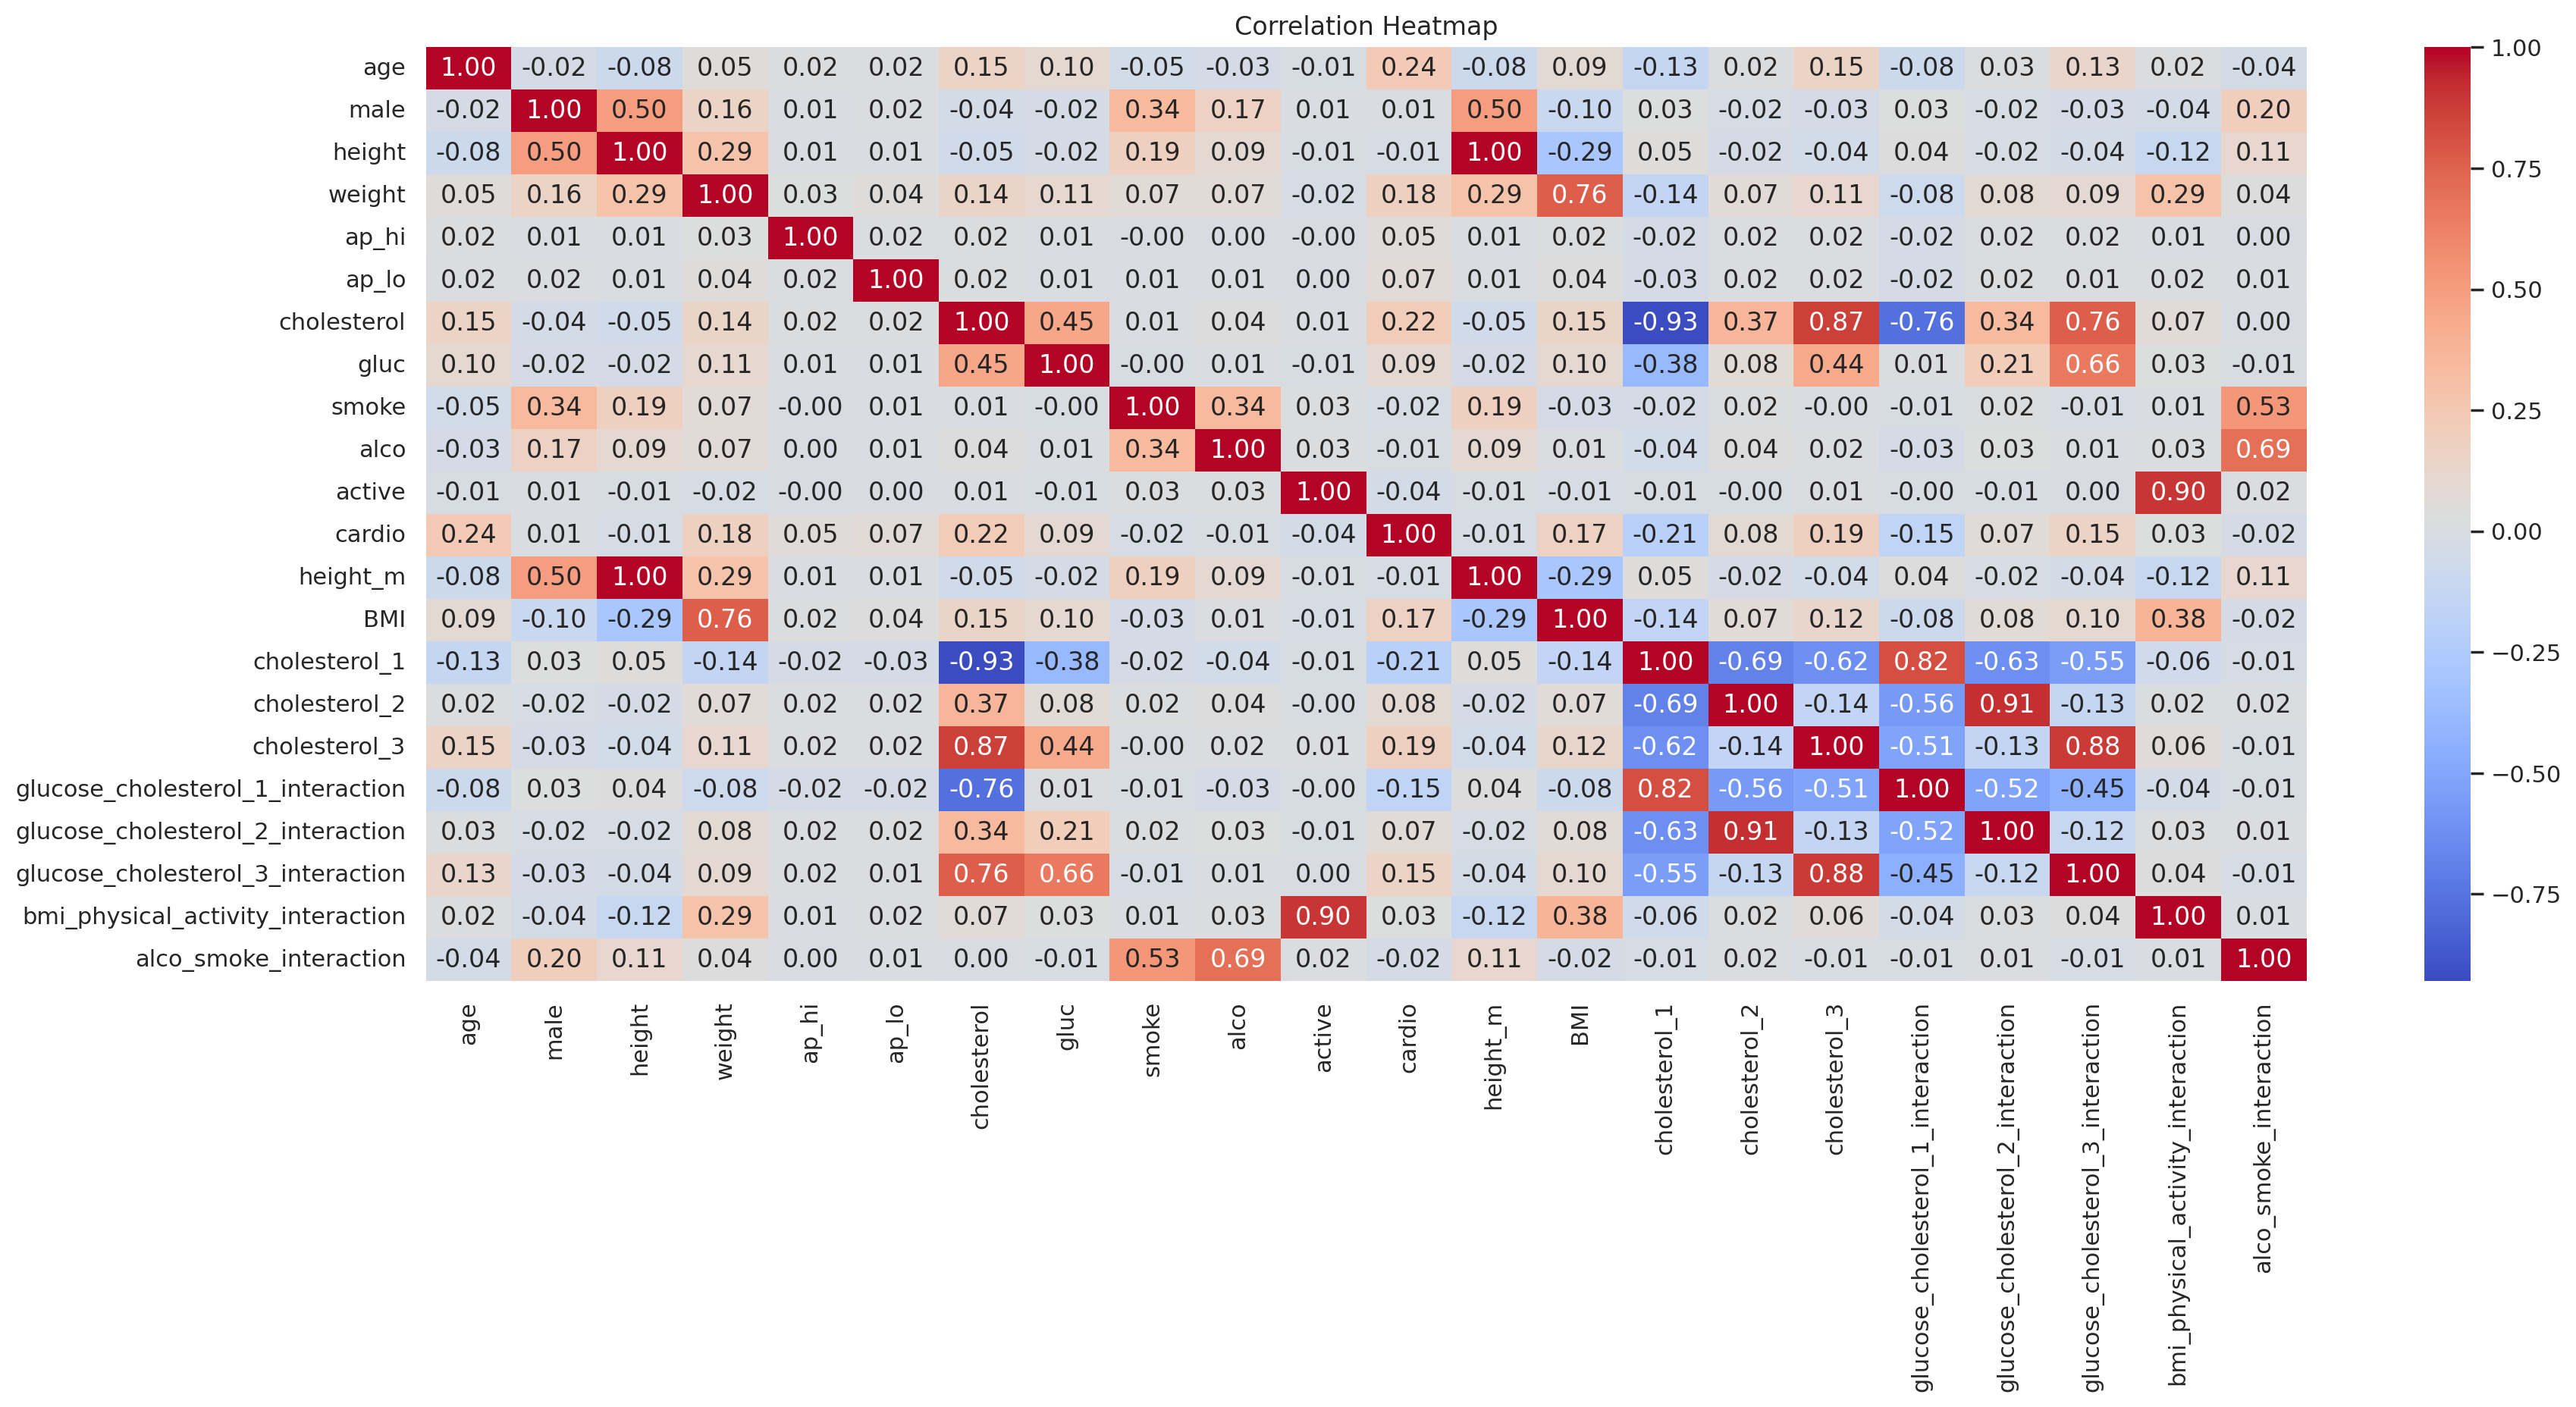

In [ ]:
corr = df2.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
selected_features = [
    'glucose_cholesterol_3_interaction',
    'glucose_cholesterol_2_interaction',
    'glucose_cholesterol_1_interaction',
    'alco_smoke_interaction'
]
correlation_matrix = df2[selected_features].corr()
print(correlation_matrix)

                                   glucose_cholesterol_3_interaction  \
glucose_cholesterol_3_interaction                           1.000000   
glucose_cholesterol_2_interaction                          -0.115724   
glucose_cholesterol_1_interaction                          -0.451593   
alco_smoke_interaction                                     -0.011015   

                                   glucose_cholesterol_2_interaction  \
glucose_cholesterol_3_interaction                          -0.115724   
glucose_cholesterol_2_interaction                           1.000000   
glucose_cholesterol_1_interaction                          -0.515158   
alco_smoke_interaction                                      0.014607   

                                   glucose_cholesterol_1_interaction  \
glucose_cholesterol_3_interaction                          -0.451593   
glucose_cholesterol_2_interaction                          -0.515158   
glucose_cholesterol_1_interaction                           1.

In [ ]:
vif_data = df2[selected_features]
vif = pd.DataFrame()
vif["Feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns))]
print(vif)

                             Feature       VIF
0  glucose_cholesterol_3_interaction  1.001560
1  glucose_cholesterol_2_interaction  1.004890
2  glucose_cholesterol_1_interaction  1.017122
3             alco_smoke_interaction  1.023572


In [ ]:
selected_features = ['age','weight','height', 'ap_hi', 'ap_lo', 'BMI']
numerical_features = df2[selected_features]
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)
X[selected_features] = numerical_features_scaled

In [ ]:
data1 = df2[['age', 'male', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',              # Includes both interaction terms and individual terms
             'gluc', 'smoke', 'alco', 'active', 'cardio', 'height', 'BMI',
             'cholesterol_1', 'cholesterol_2', 'cholesterol_3','bmi_physical_activity_interaction',
             'glucose_cholesterol_1_interaction',
             'glucose_cholesterol_2_interaction',
             'glucose_cholesterol_3_interaction', 'alco_smoke_interaction']]


In [ ]:
data2 = df2[['age', 'male', 'ap_hi', 'ap_lo',   # Just the Interaction Terms
          'cardio','BMI','bmi_physical_activity_interaction',
       'glucose_cholesterol_1_interaction',
       'glucose_cholesterol_2_interaction',
       'glucose_cholesterol_3_interaction', 'alco_smoke_interaction']]

In [ ]:
data3 = df2[['age', 'male', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',       #Only the individual terms
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'height', 'BMI',
       'cholesterol_1', 'cholesterol_2', 'cholesterol_3']]

In [ ]:
test = df2['cardio'].value_counts()
test  #We do not have class balancement issues

0    35021
1    34979
Name: cardio, dtype: int64

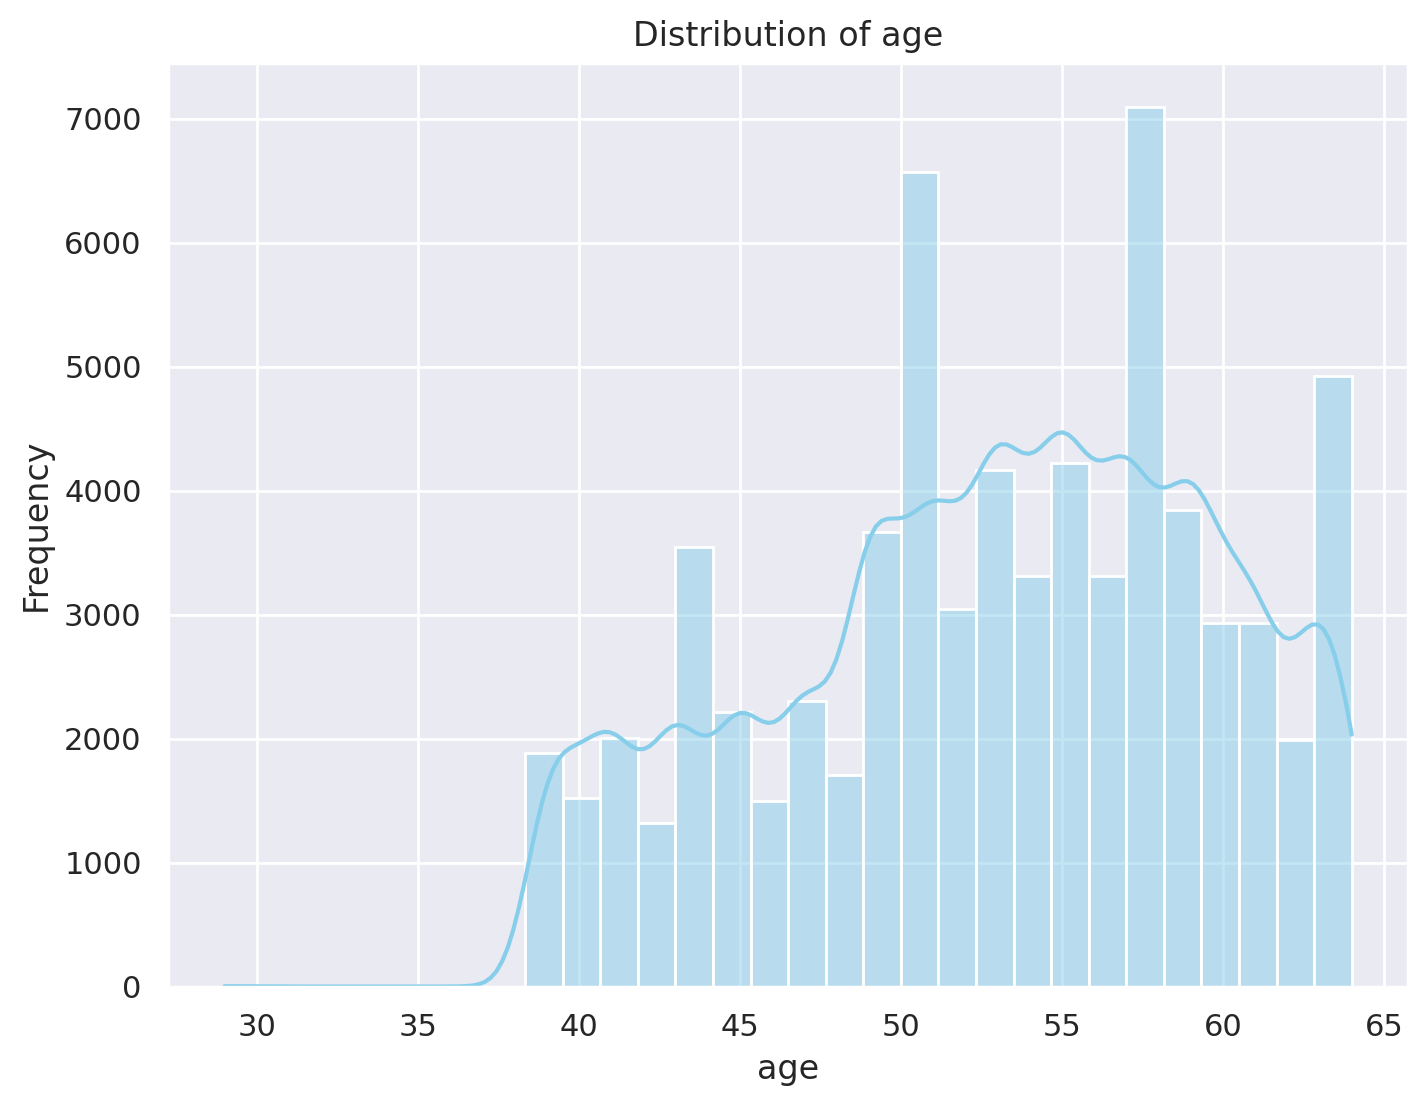

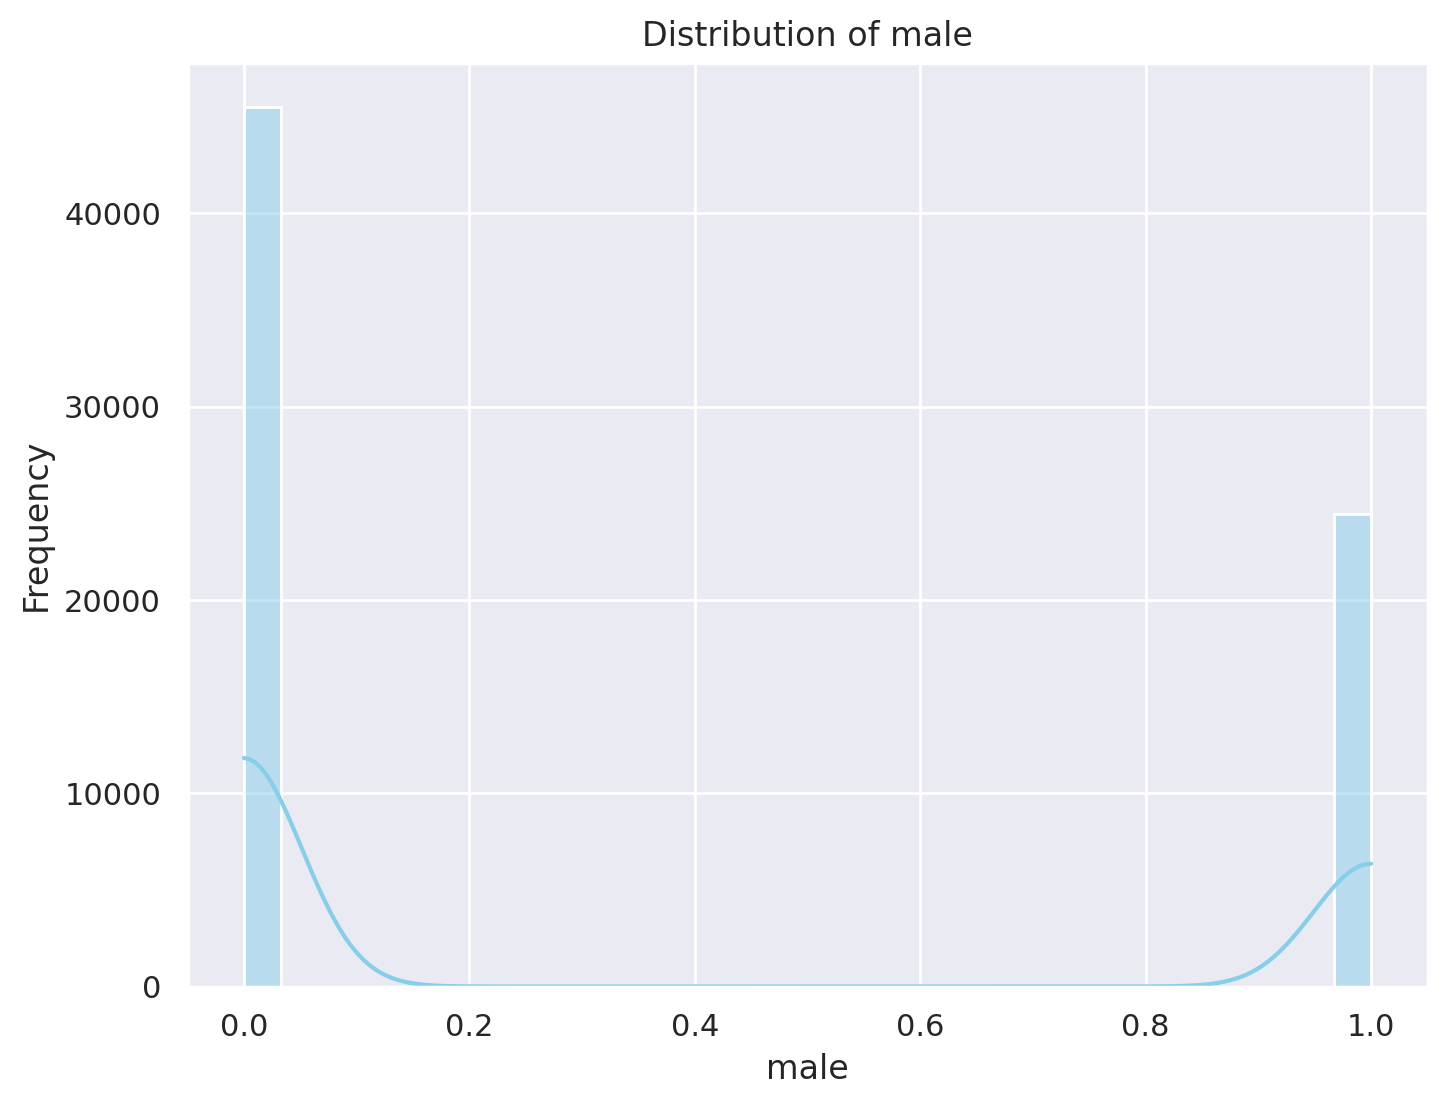

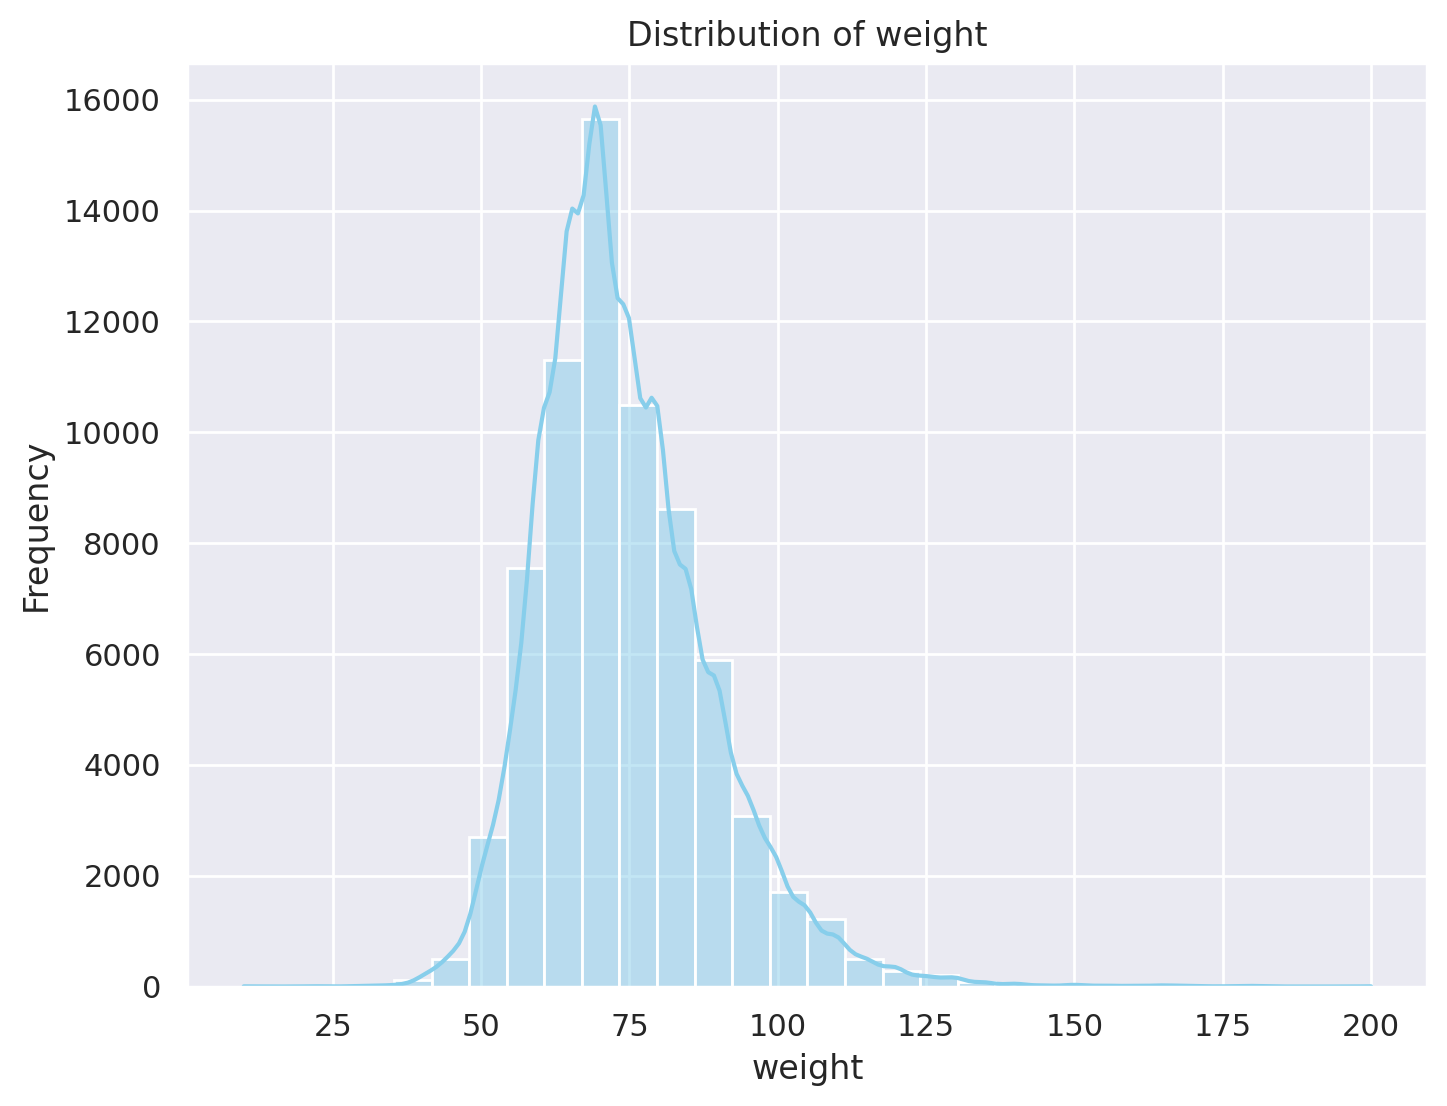

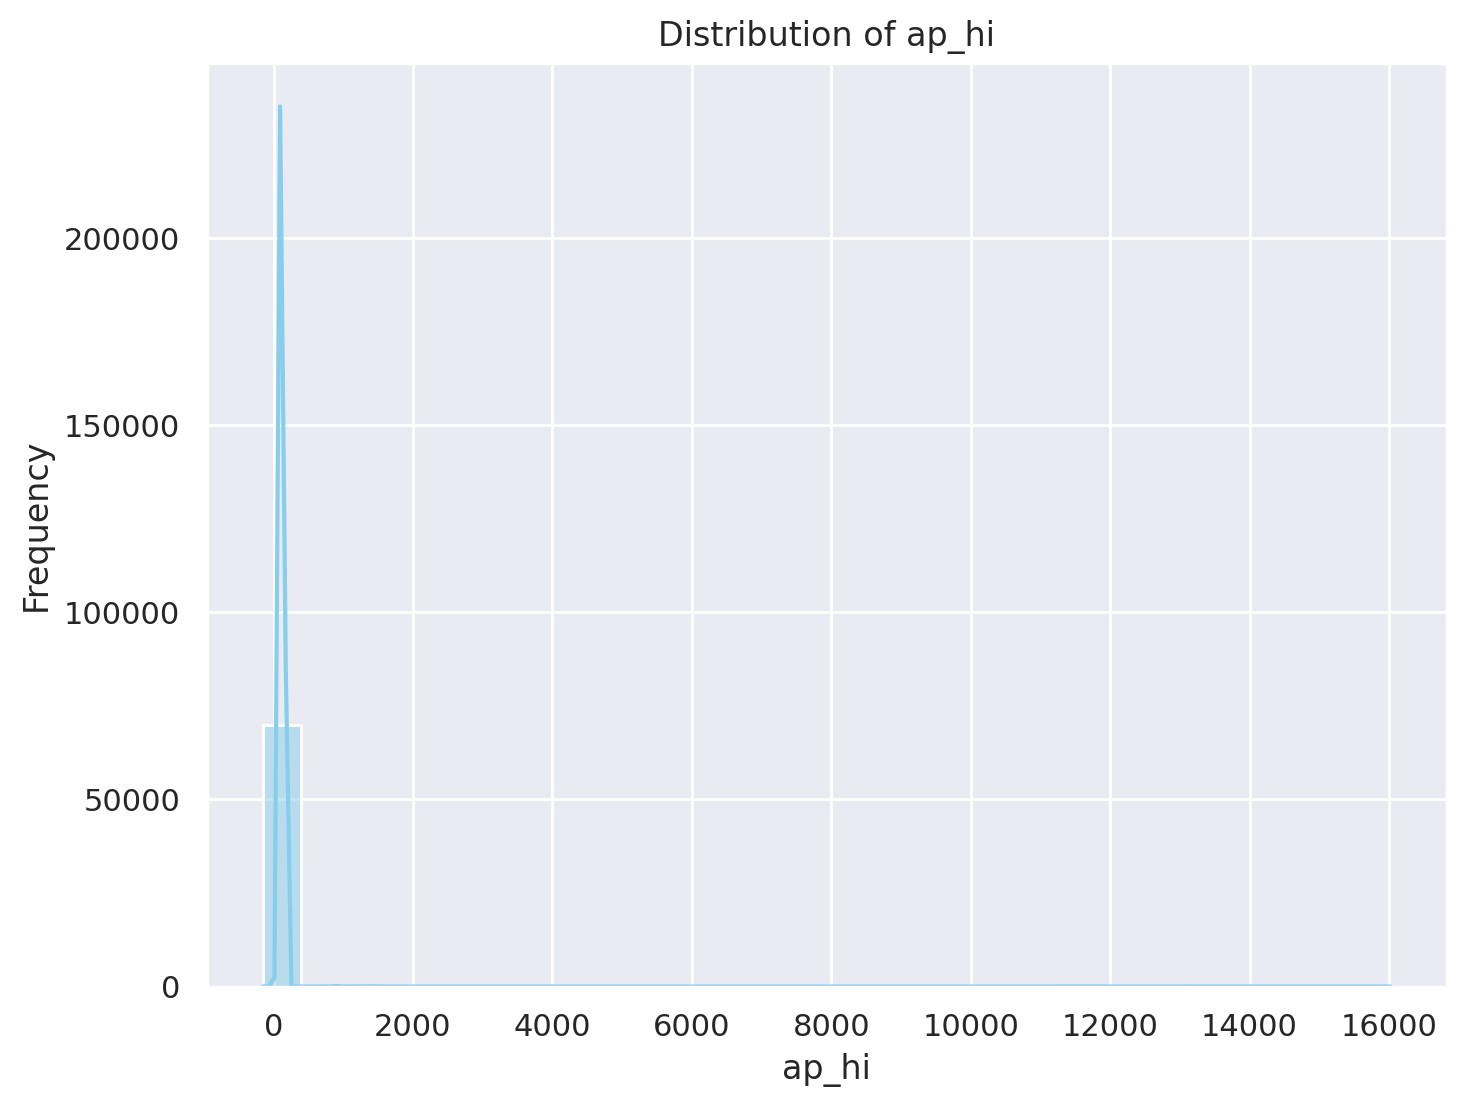

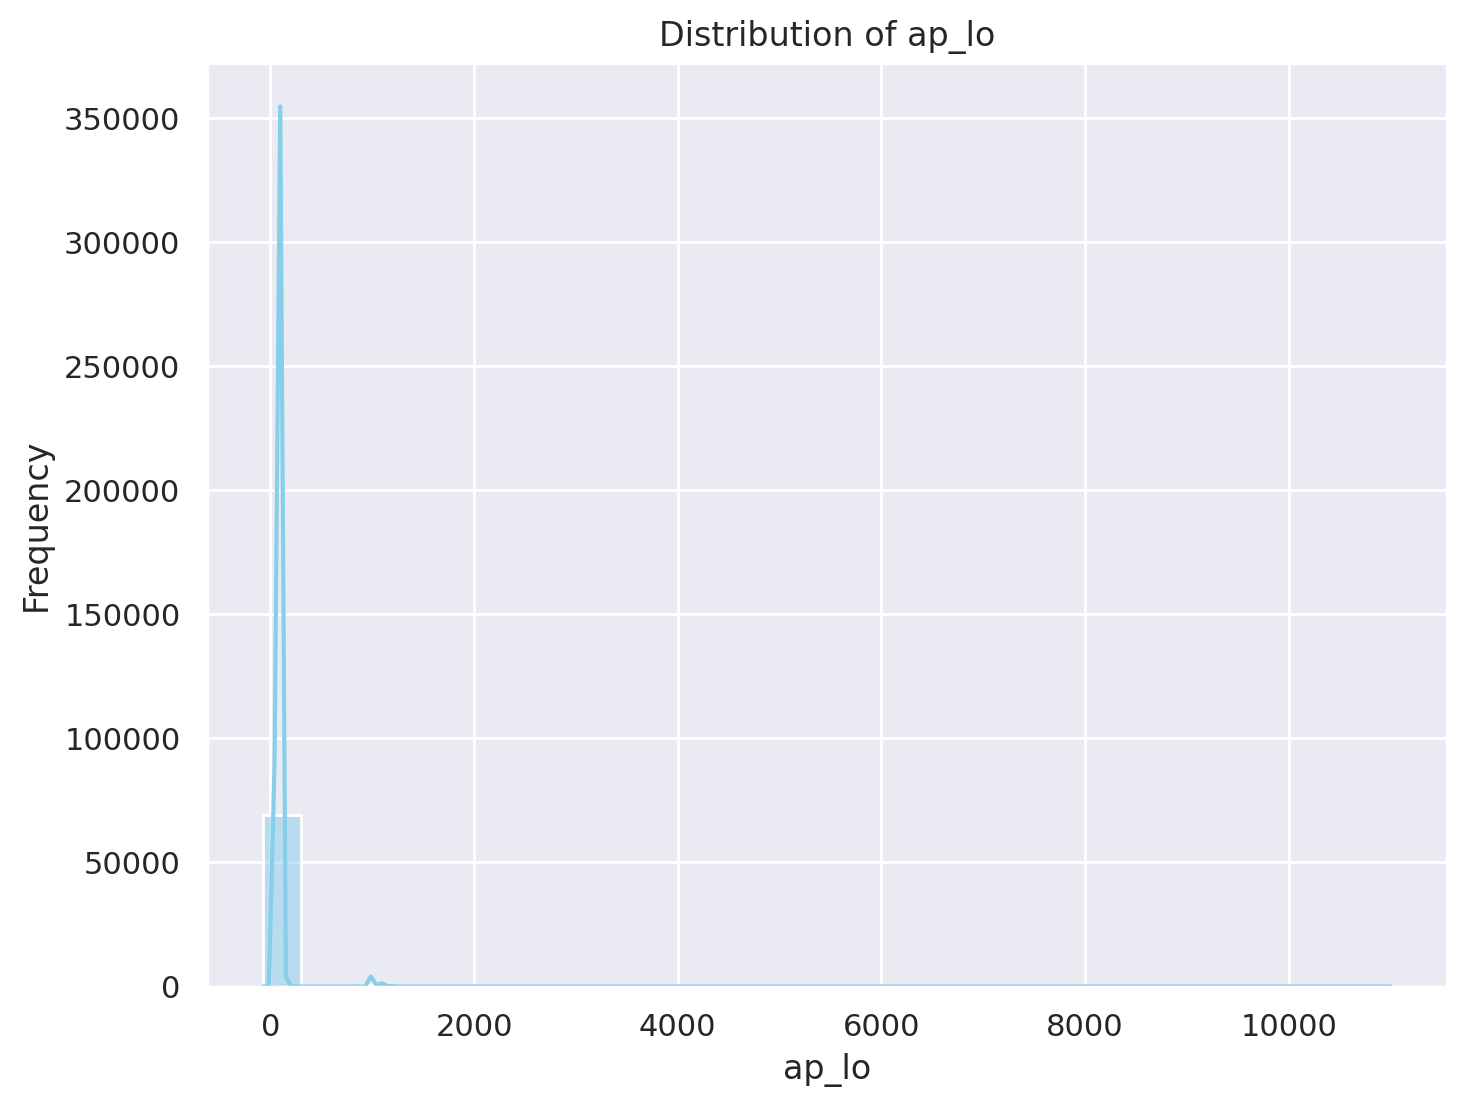

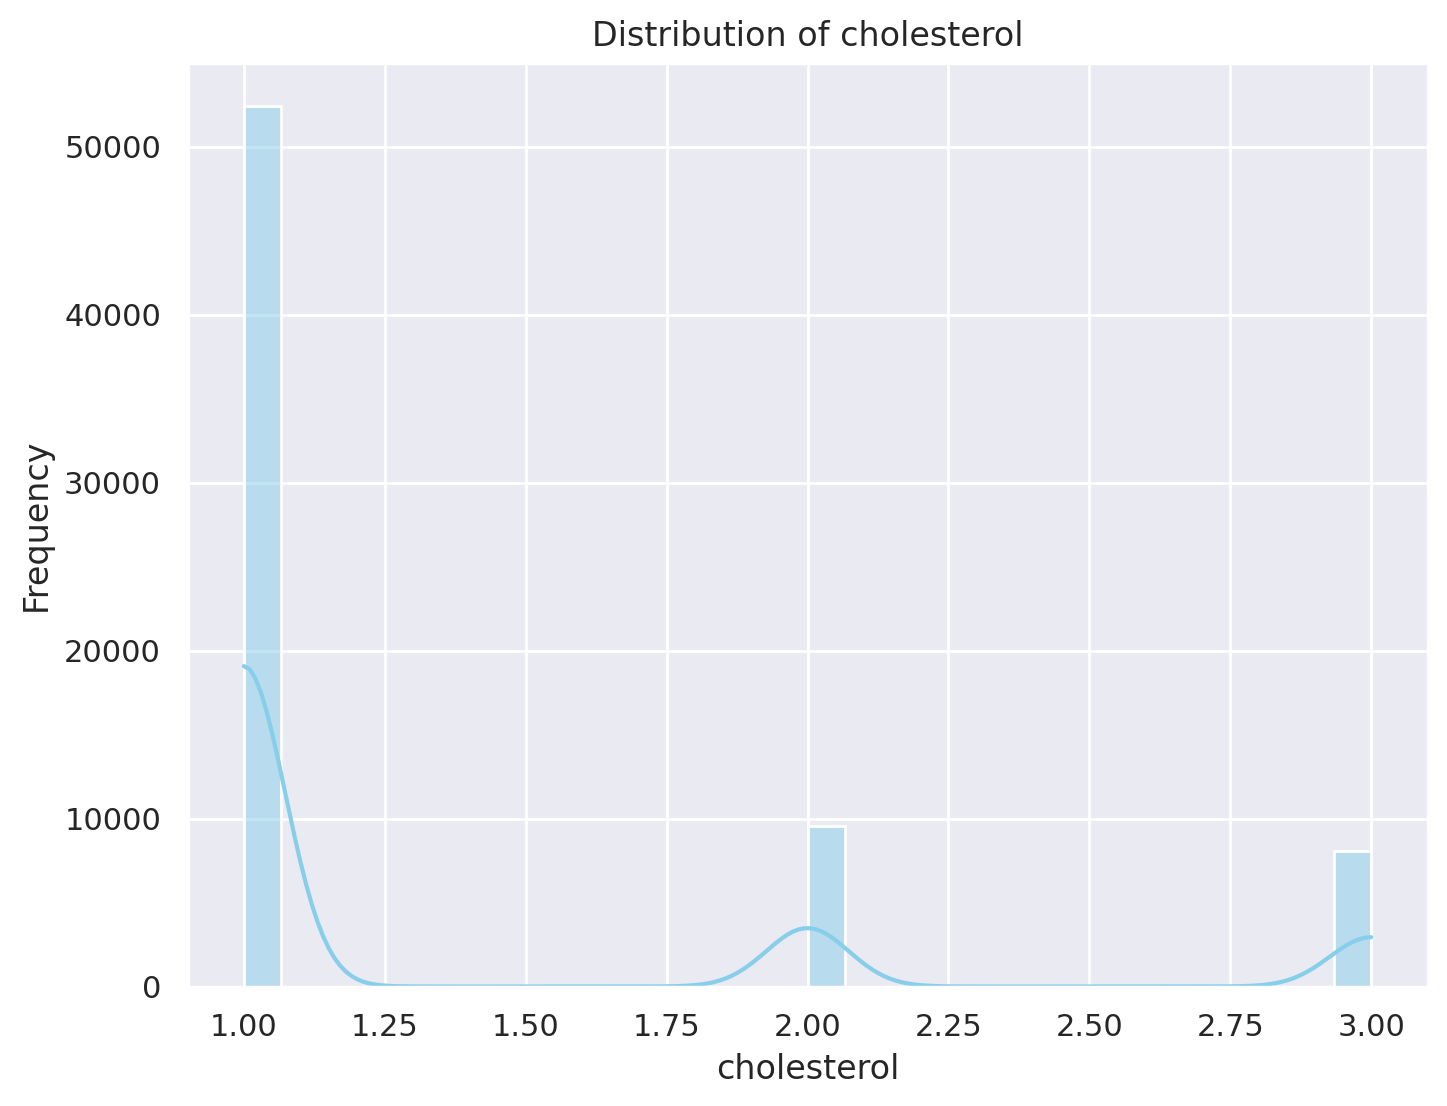

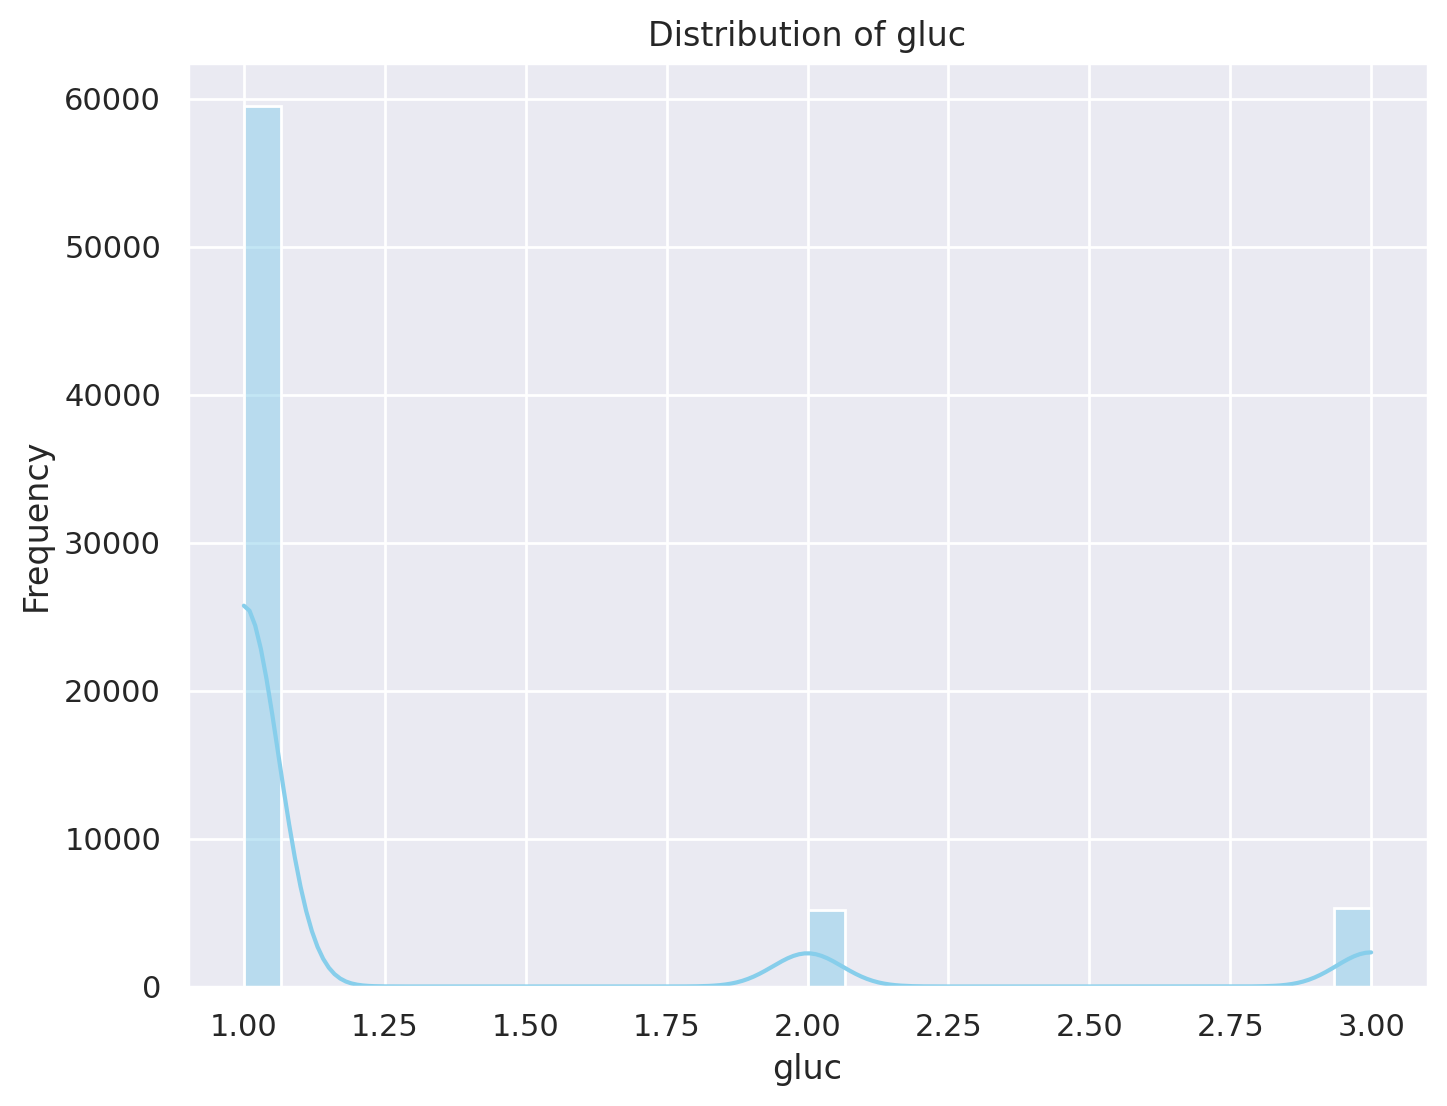

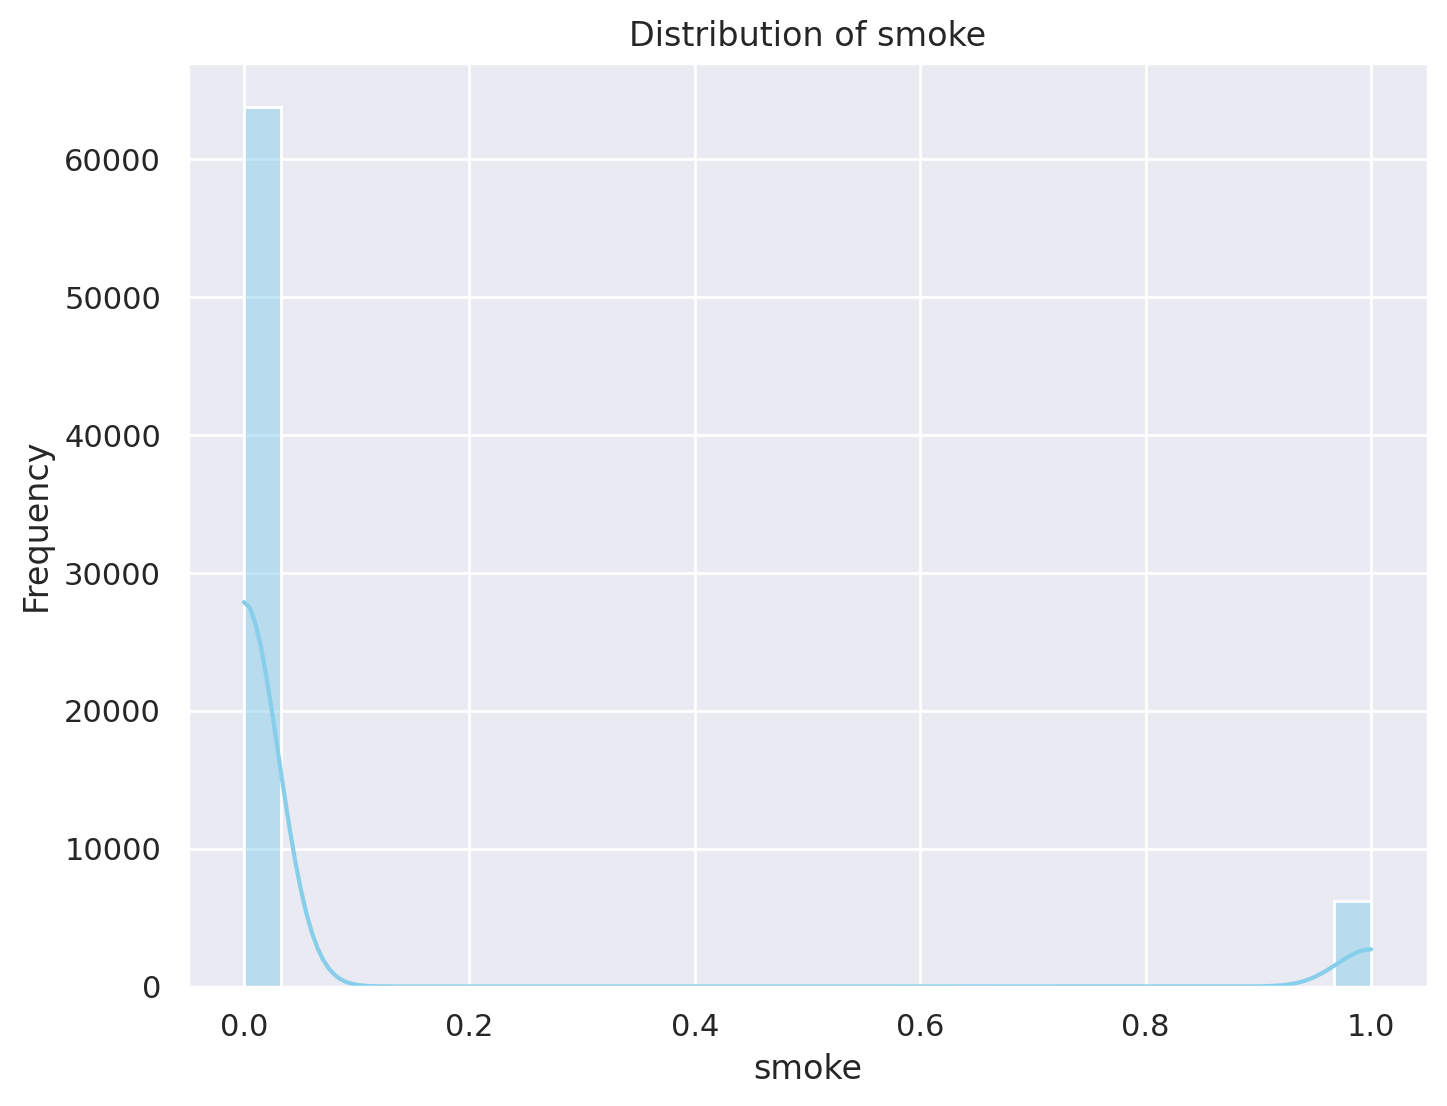

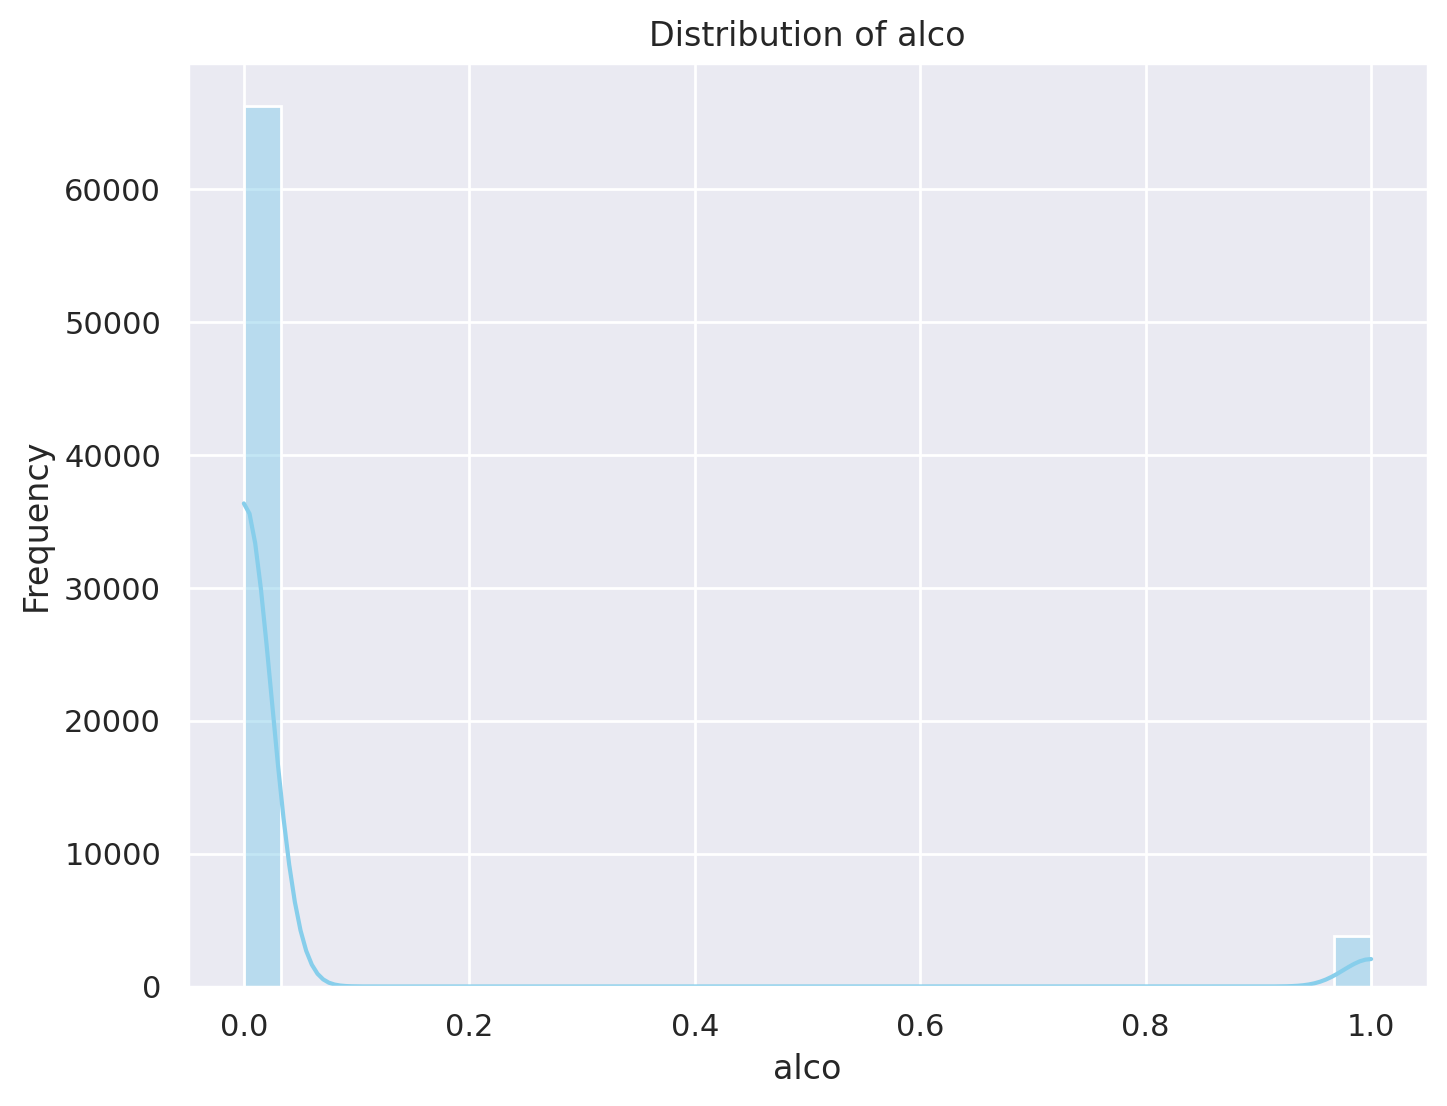

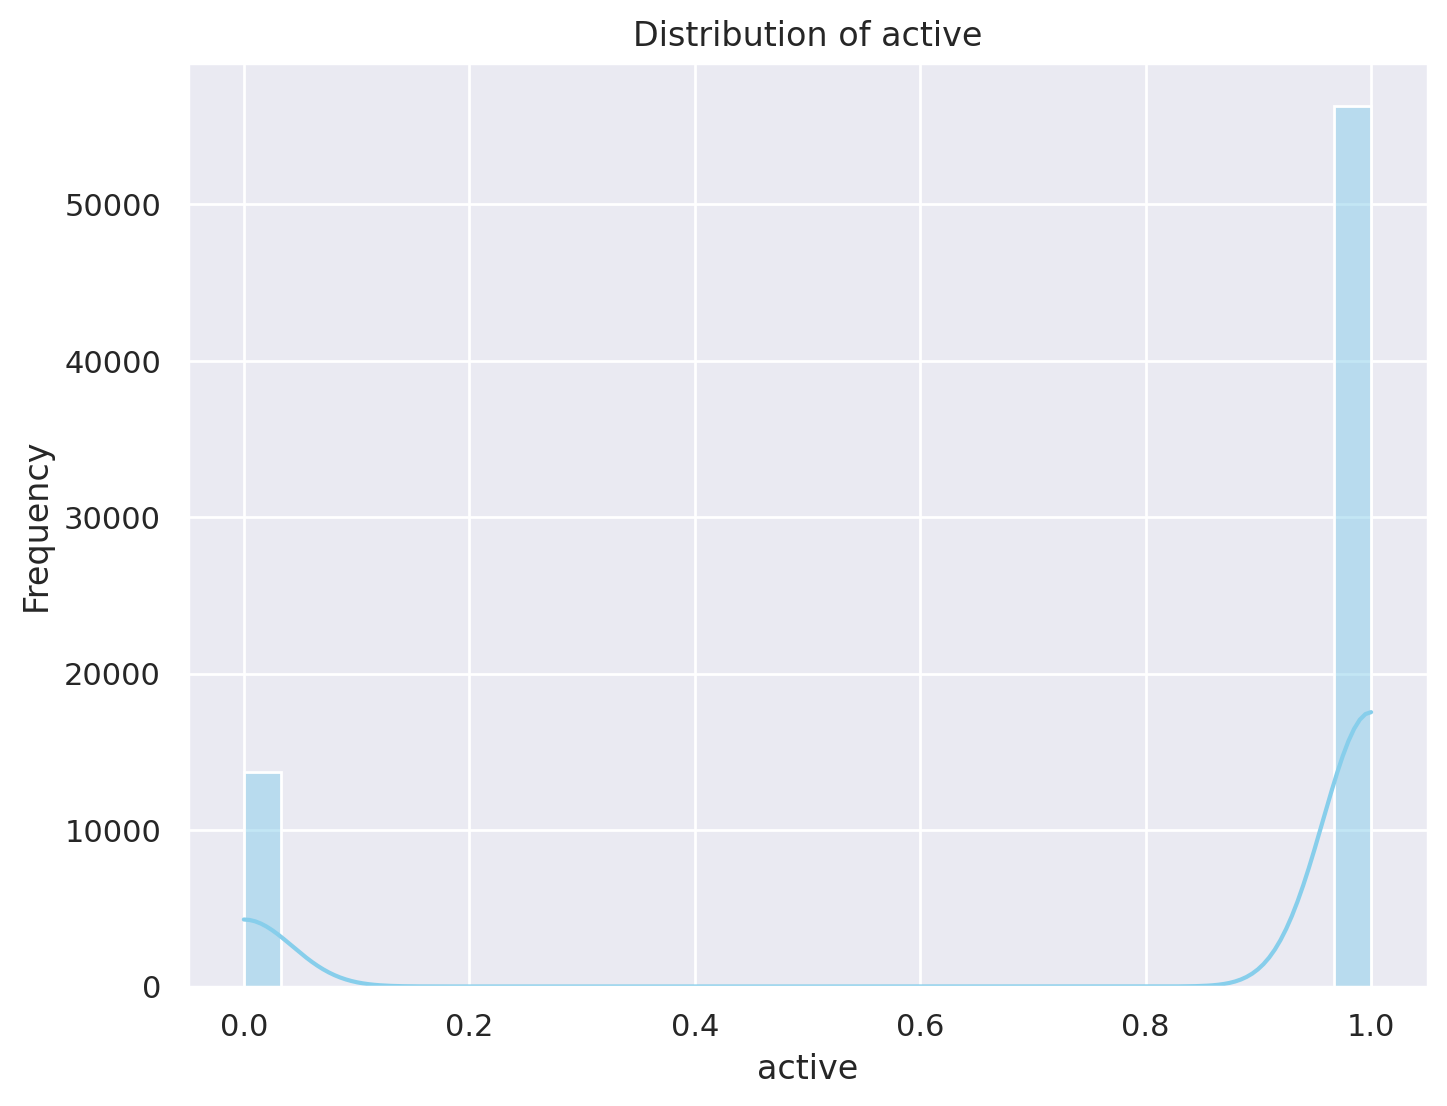

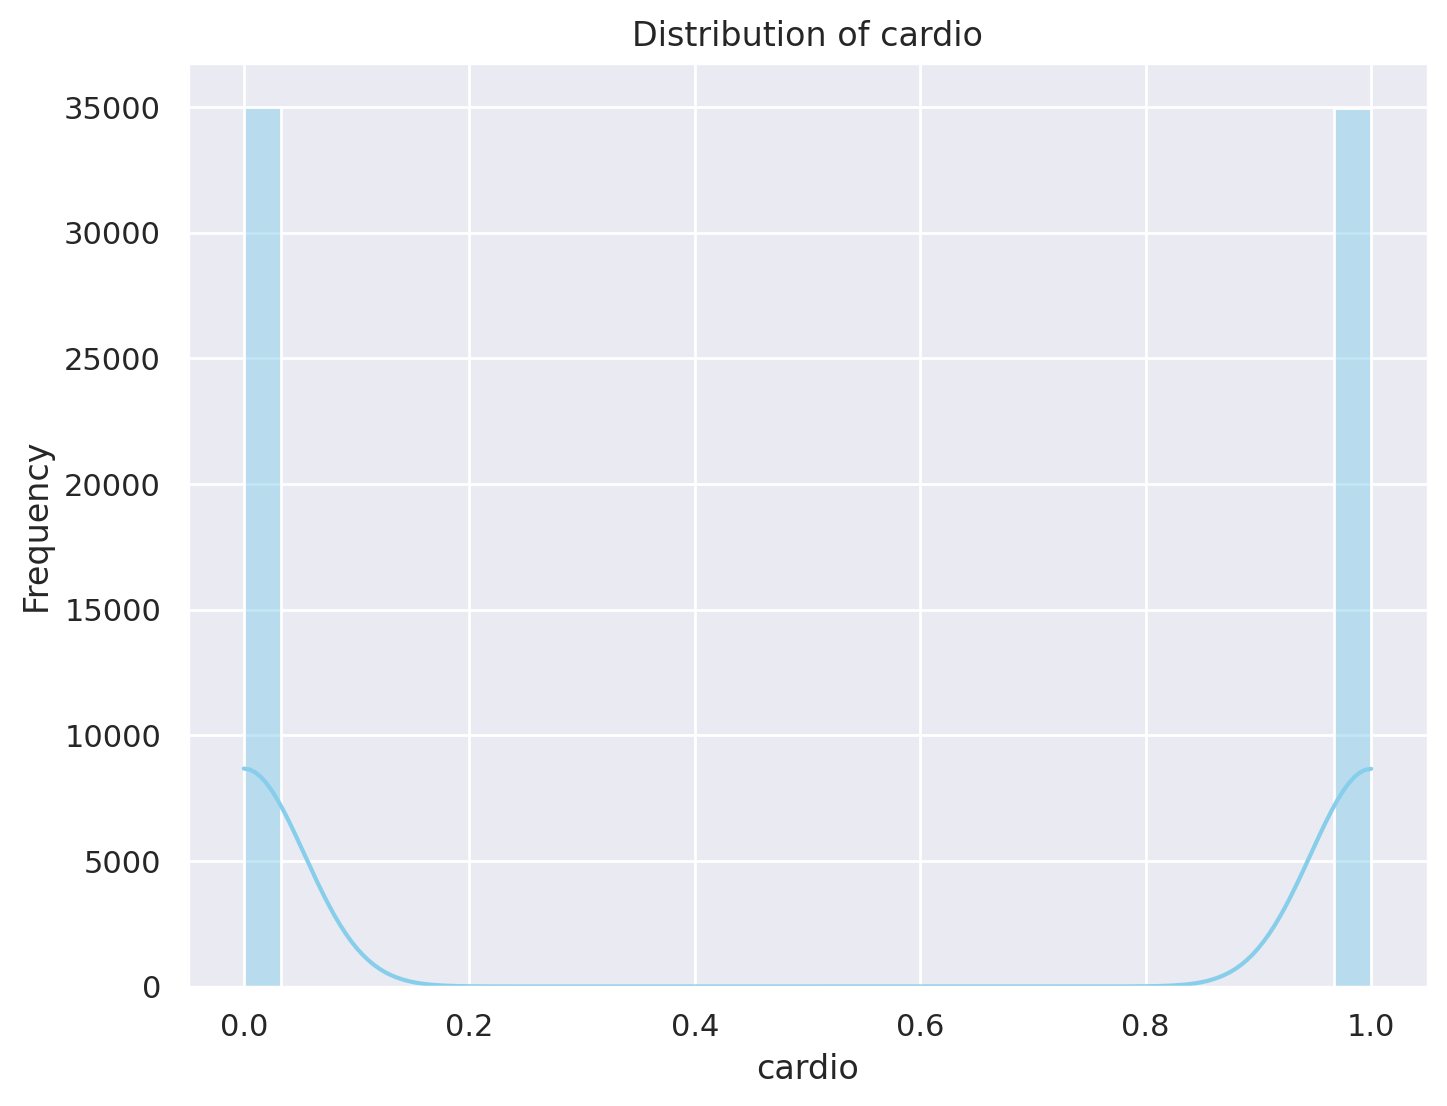

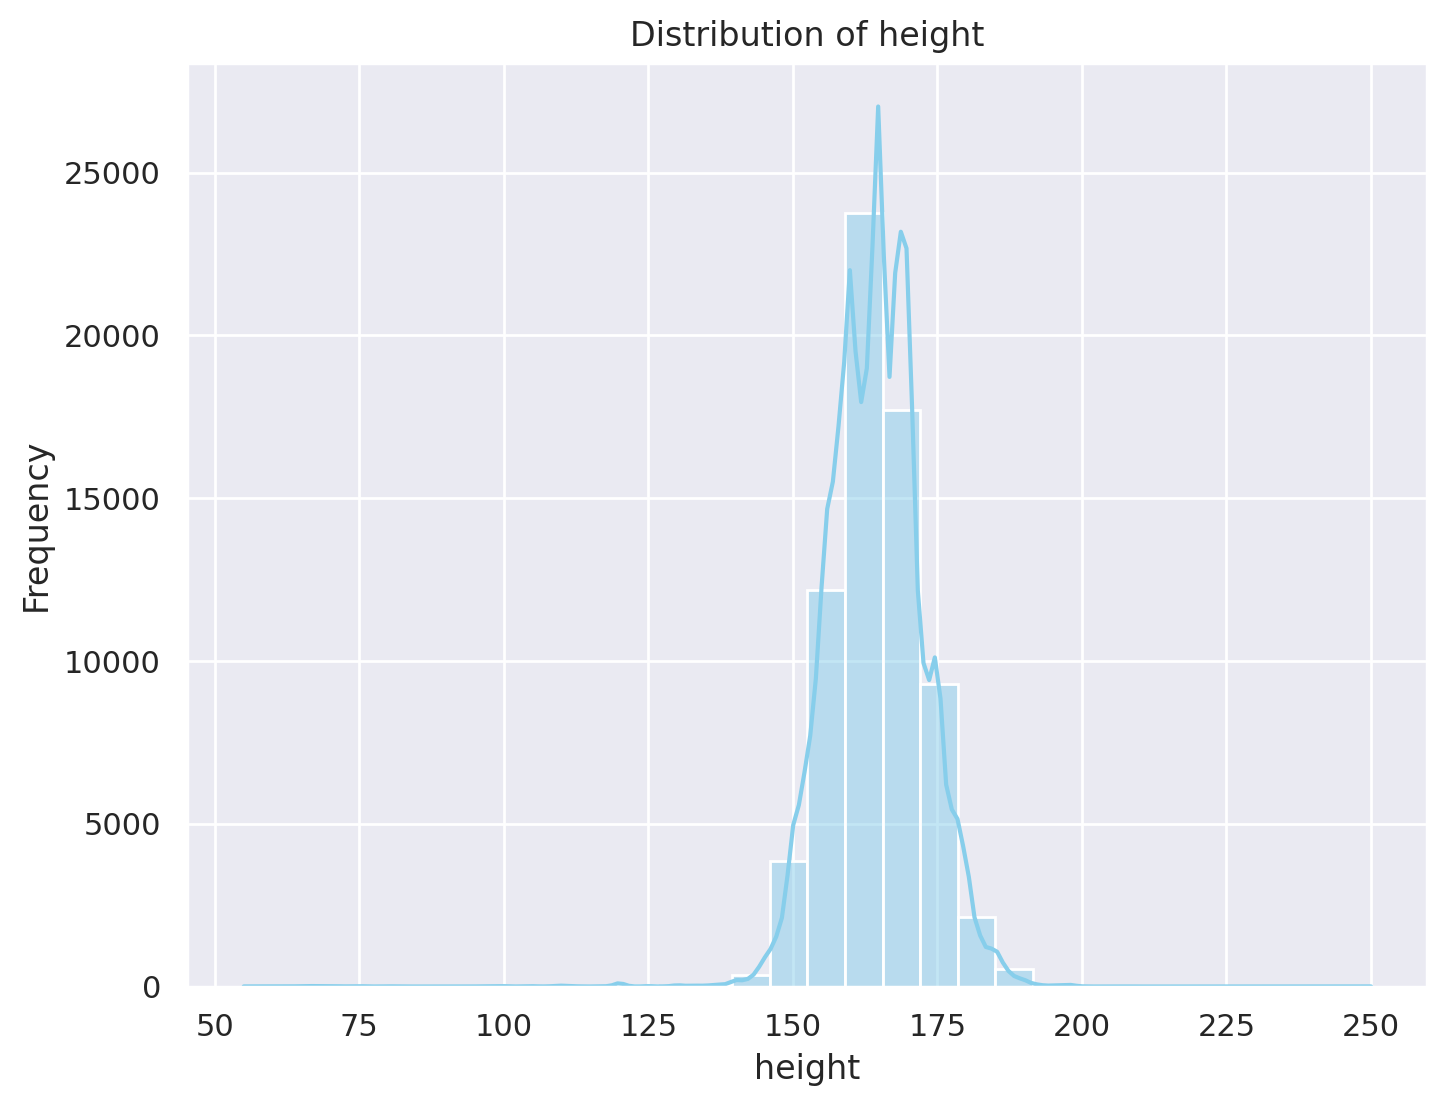

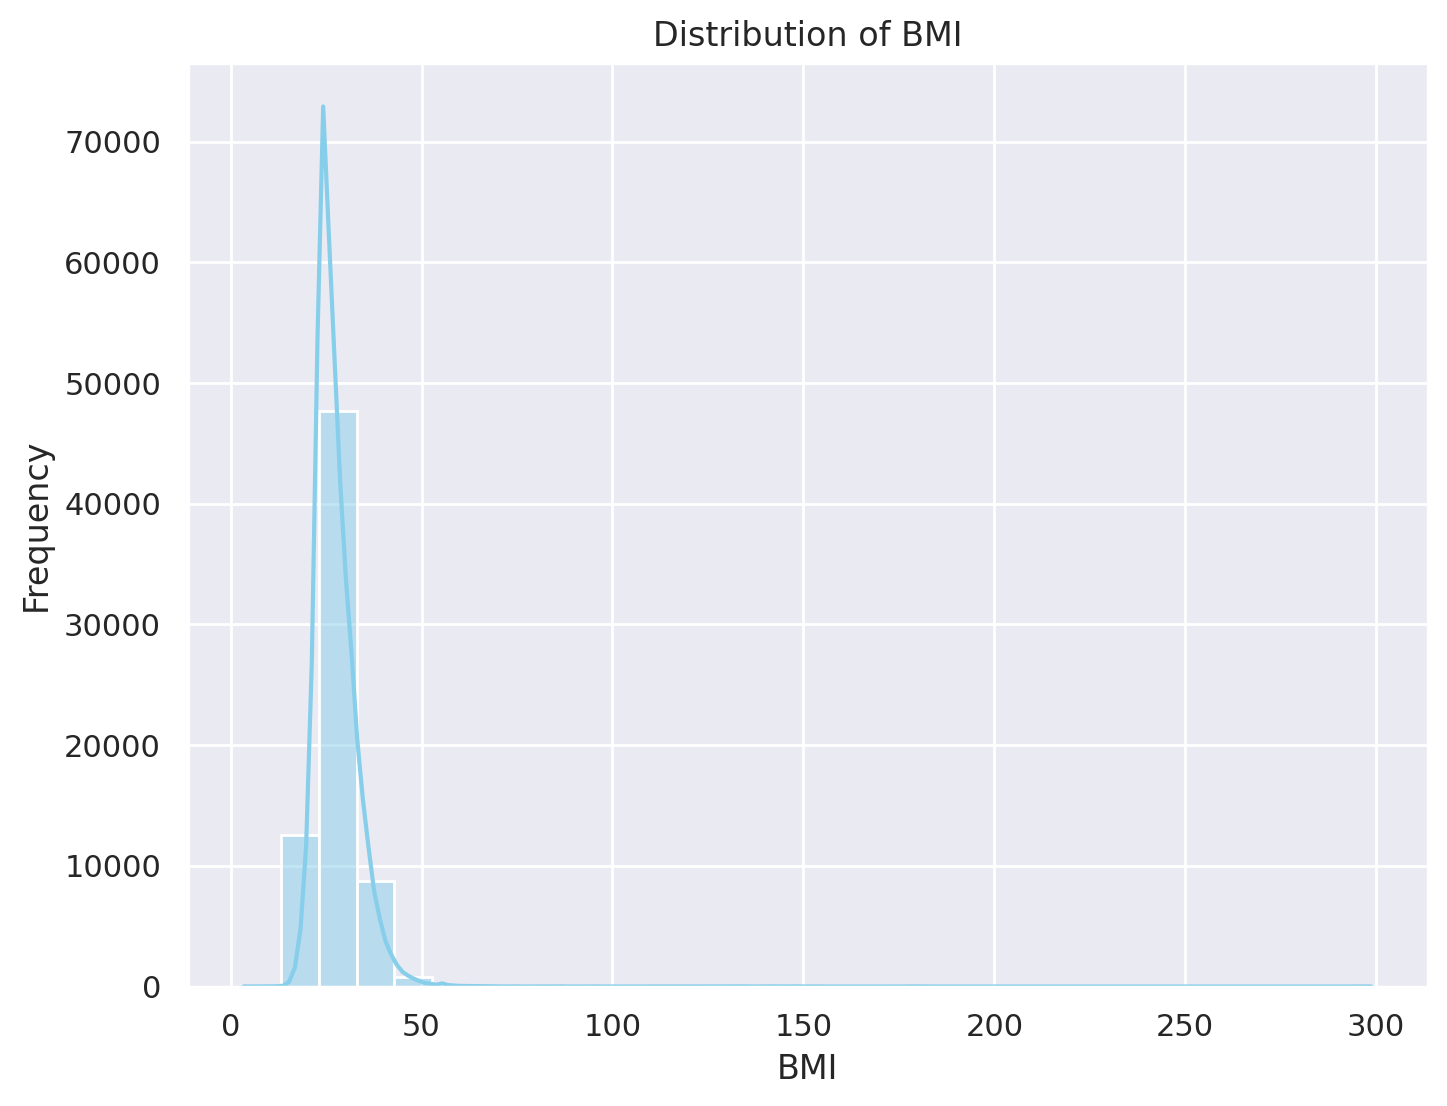

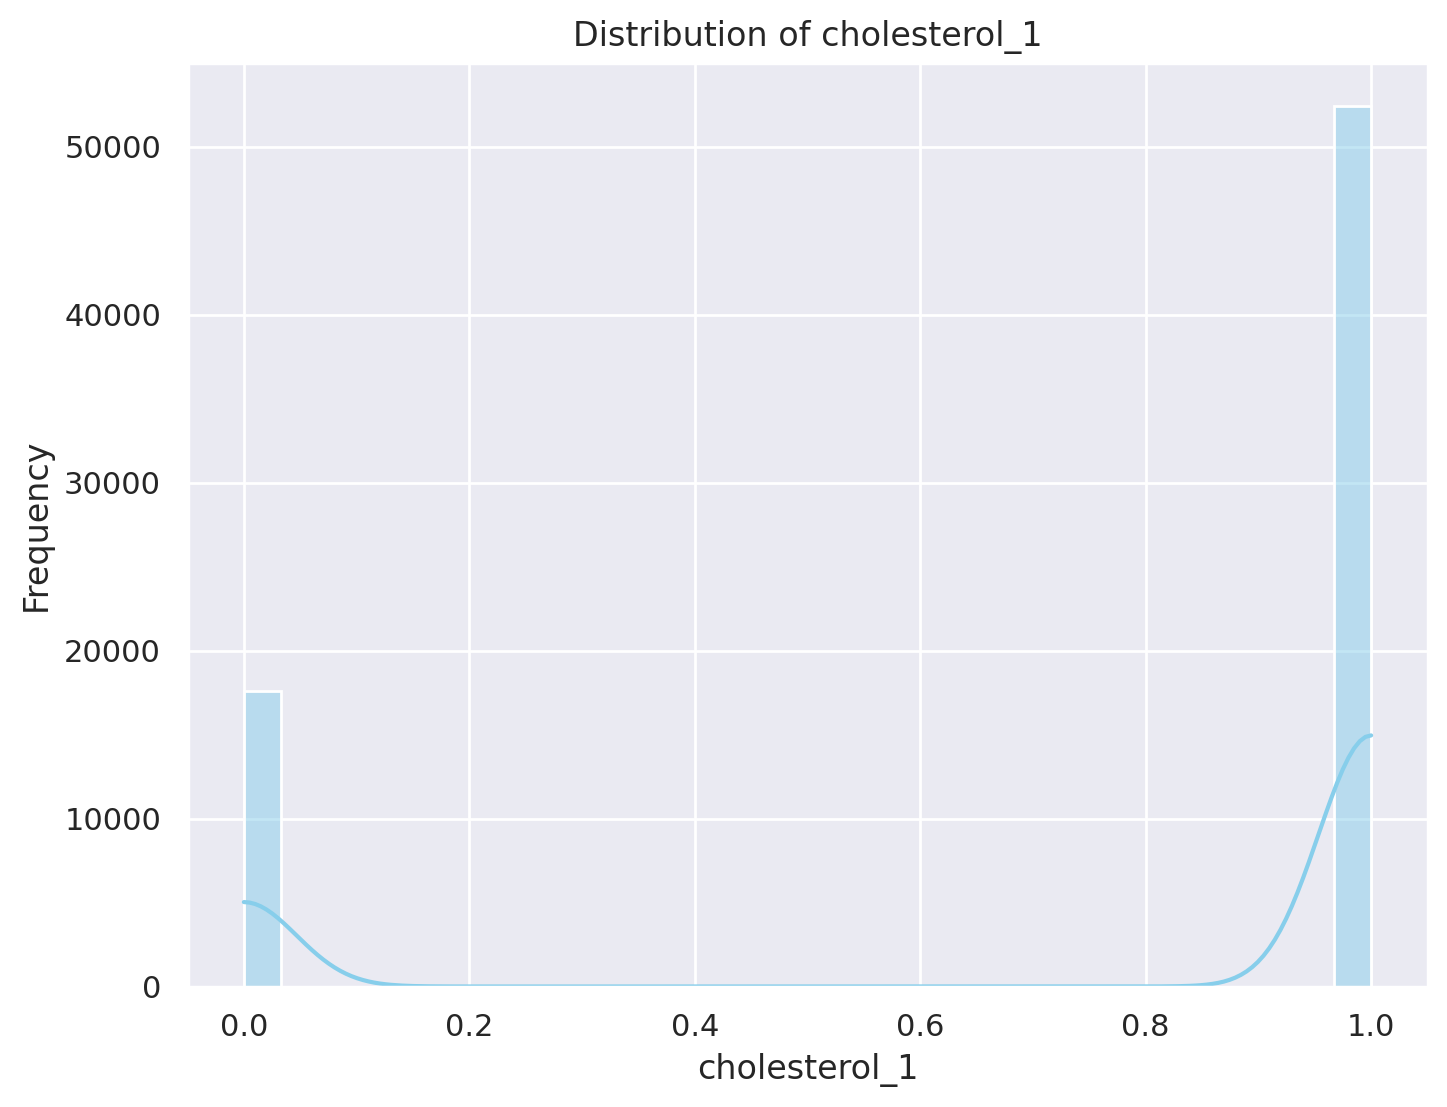

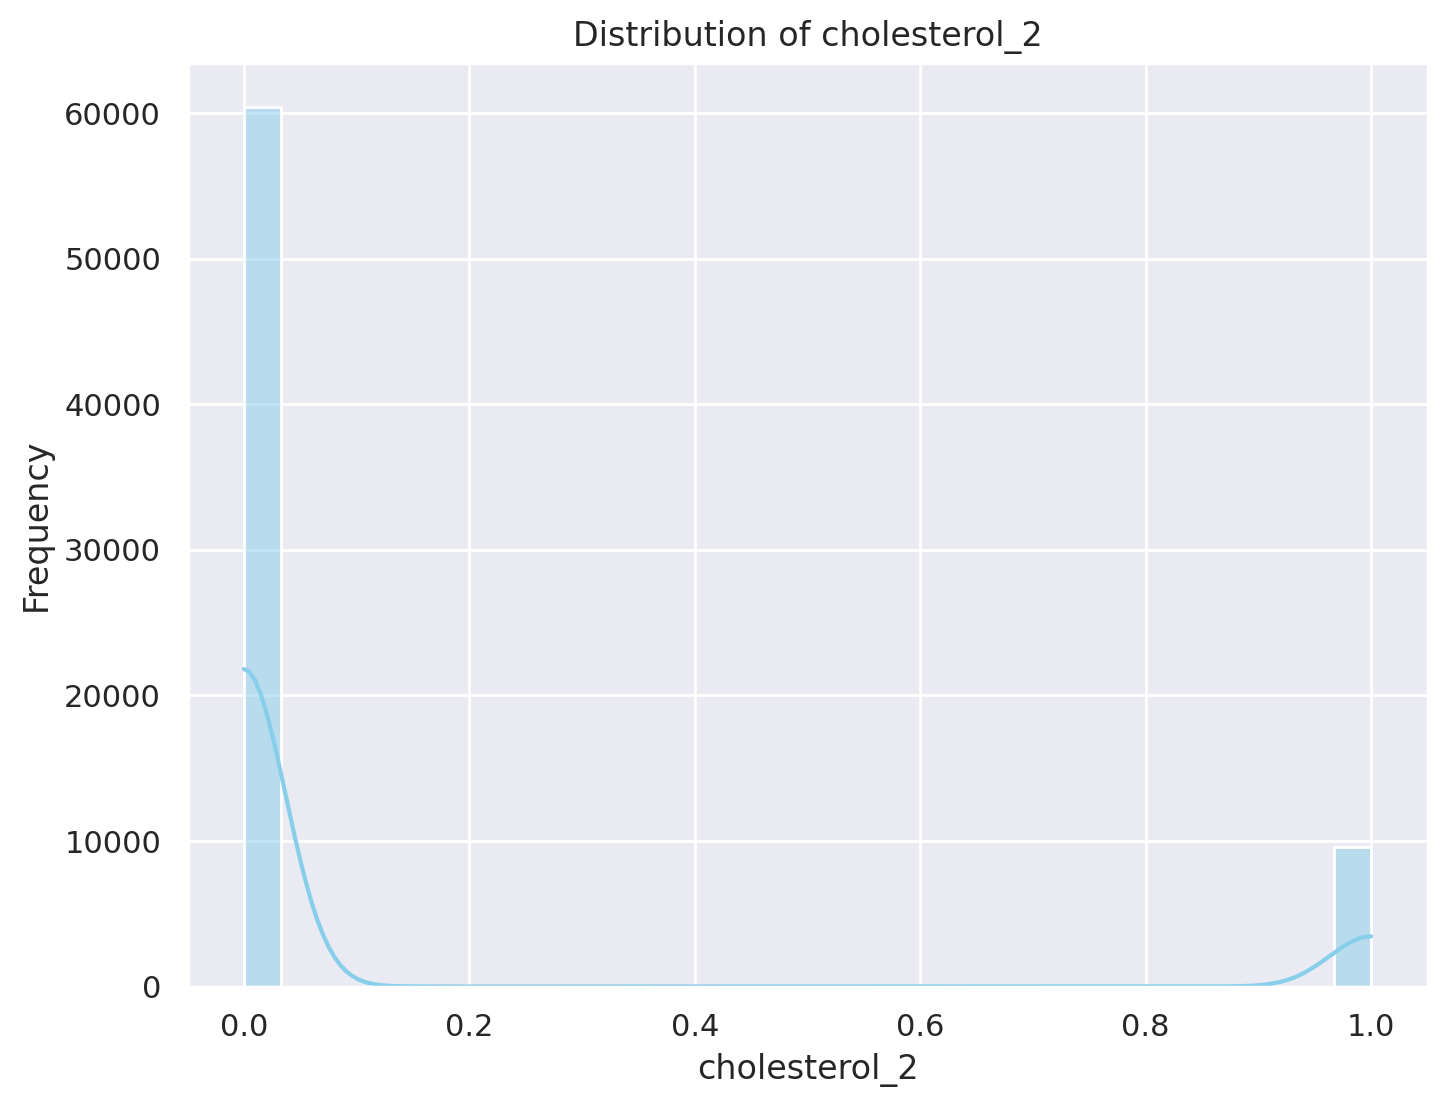

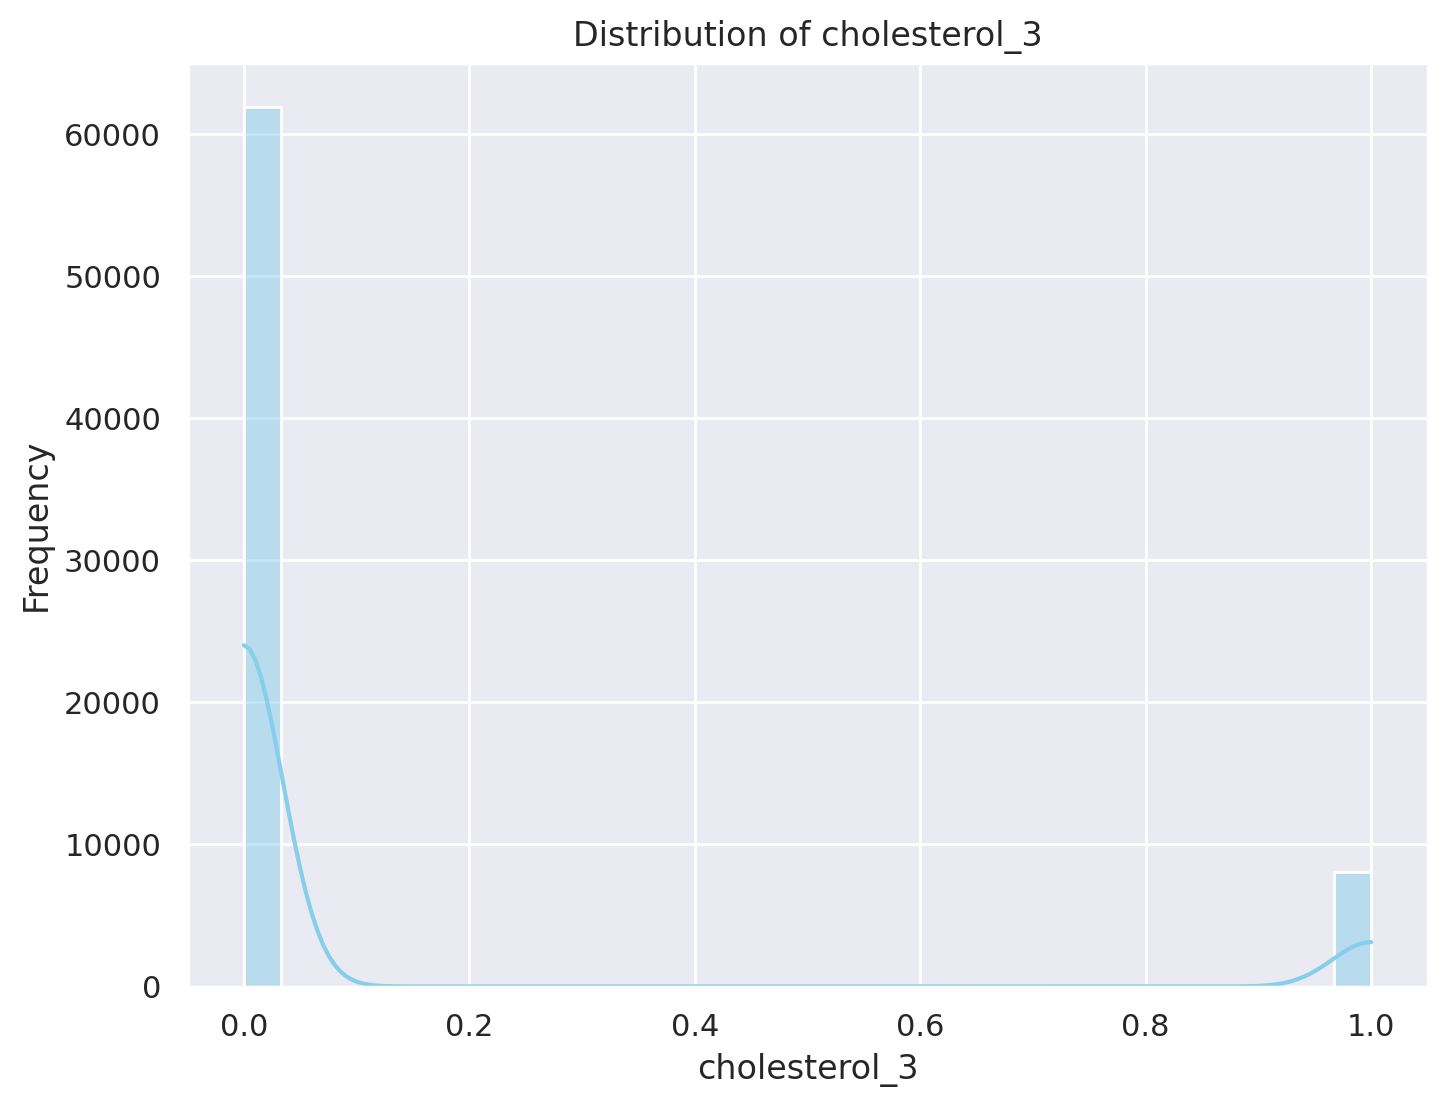

In [ ]:
for column in data3.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df2[column], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

As we can see most of the numerical features are normally distributed but few of the categorical features have class imbalancement but i do not think hhaving imabalancemnt within independent variables effects the model a alot


In [ ]:
data4 = df2[['age', 'male', 'ap_hi', 'ap_lo',       #Dummy variable
          'cardio','bmi_physical_activity_interaction',
       'glucose_cholesterol_1_interaction',
       'glucose_cholesterol_2_interaction',
       'glucose_cholesterol_3_interaction', 'alco_smoke_interaction']]

In [ ]:
data5 = df2[['ap_hi','cardio','age','gluc','BMI',                  #Customized data frame handpicked based on the feature performances
          'cardio','glucose_cholesterol_3_interaction' ]]

In [ ]:
X = data1.drop(columns=['cardio'])
y = data1['cardio']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)
decision_tree1 = DecisionTreeClassifier(max_depth=3, random_state=17)
decision_tree1.fit(X_train, y_train)
ac1 = decision_tree1.score(X_holdout, y_holdout)
ac1

0.7212857142857143

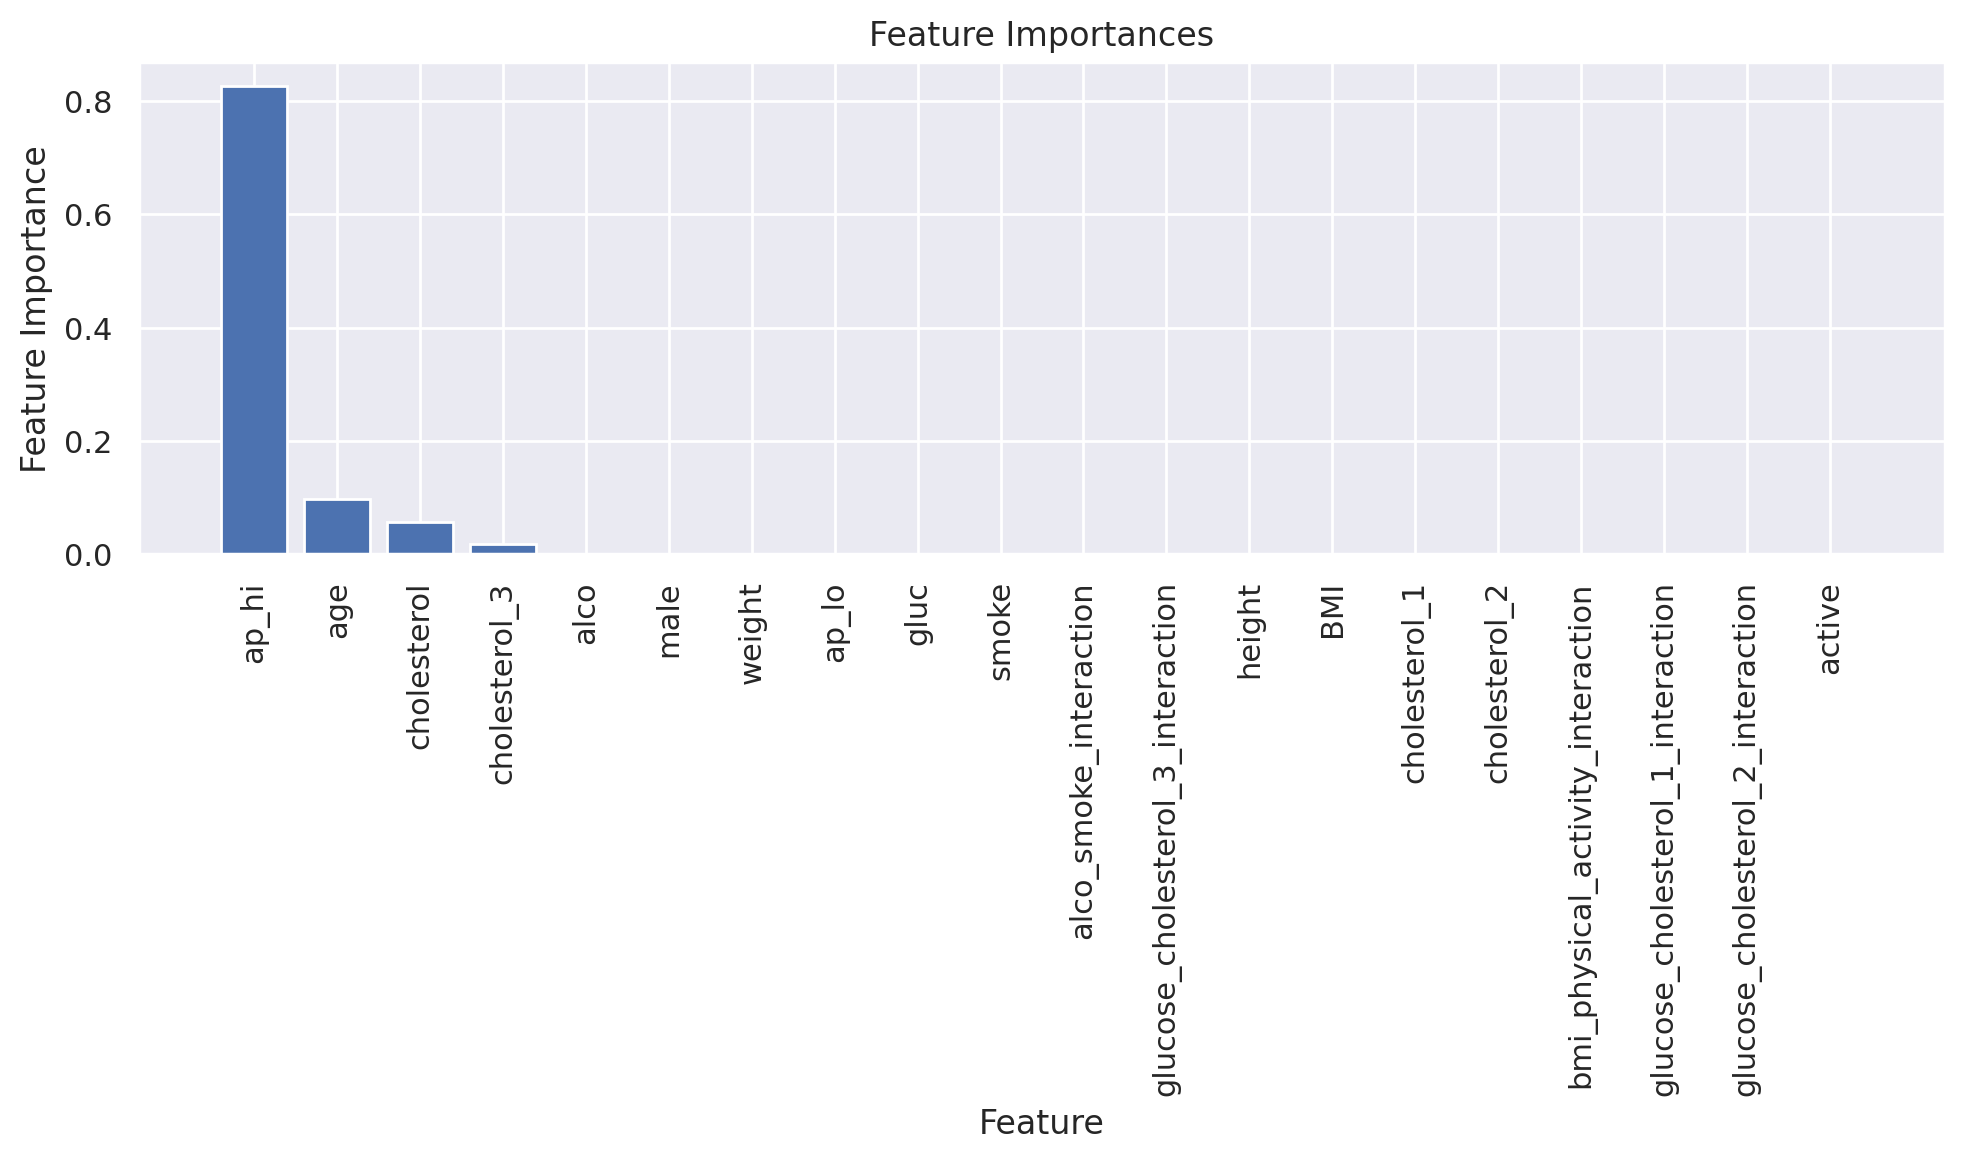

In [ ]:
importances = decision_tree1.feature_importances_
indices = importances.argsort()[::-1]

feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
X = data2.drop(columns=['cardio'])
y = data2['cardio']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)
decision_tree2 = DecisionTreeClassifier(max_depth=3, random_state=17)
decision_tree2.fit(X_train, y_train)
ac2 = decision_tree2.score(X_holdout, y_holdout)
ac2

0.7212857142857143

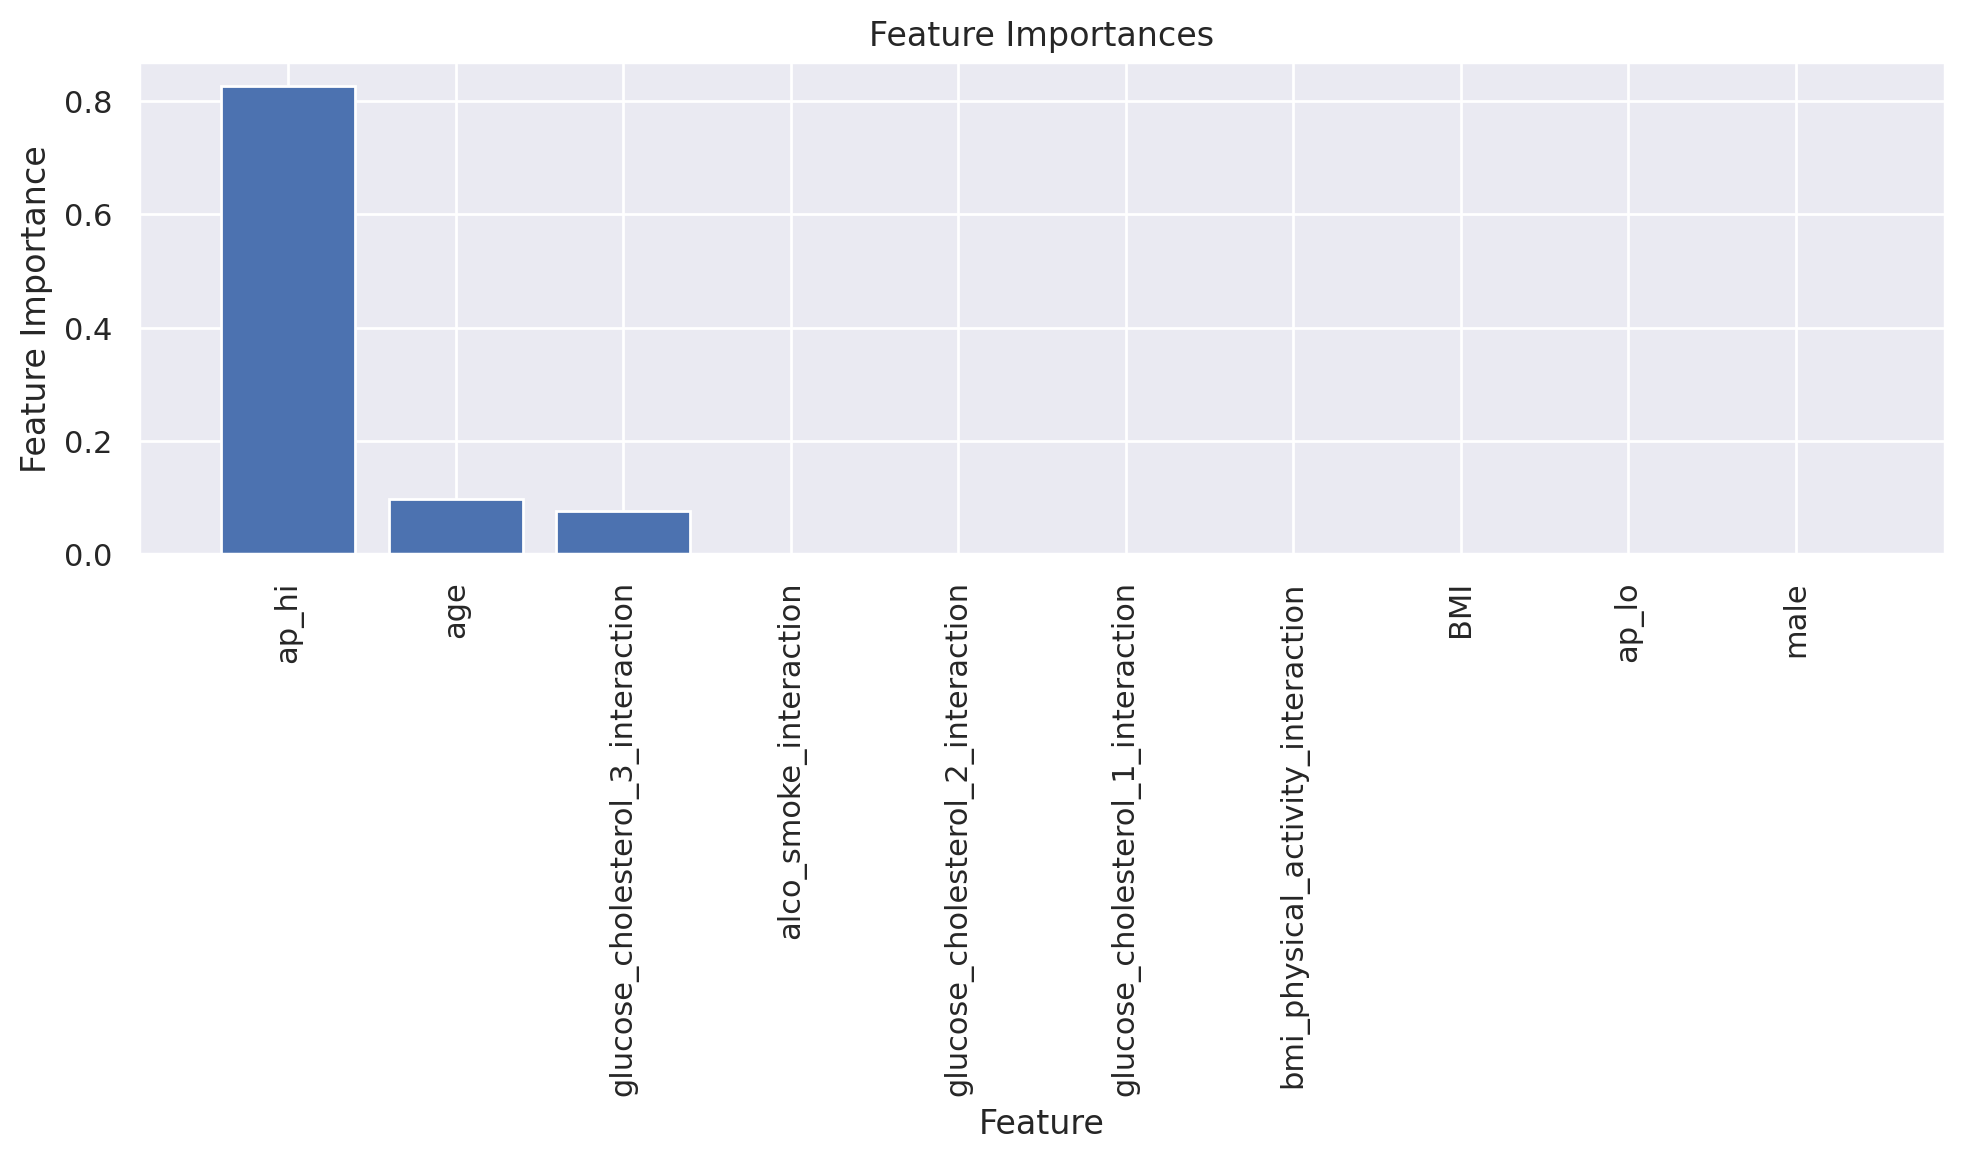

In [ ]:
importances = decision_tree2.feature_importances_
indices = importances.argsort()[::-1]
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
X = data3.drop(columns=['cardio'])
y = data3['cardio']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)
decision_tree3 = DecisionTreeClassifier(max_depth=3, random_state=17)
decision_tree3.fit(X_train, y_train)
ac3 = decision_tree3.score(X_holdout, y_holdout)
ac3

0.7212857142857143

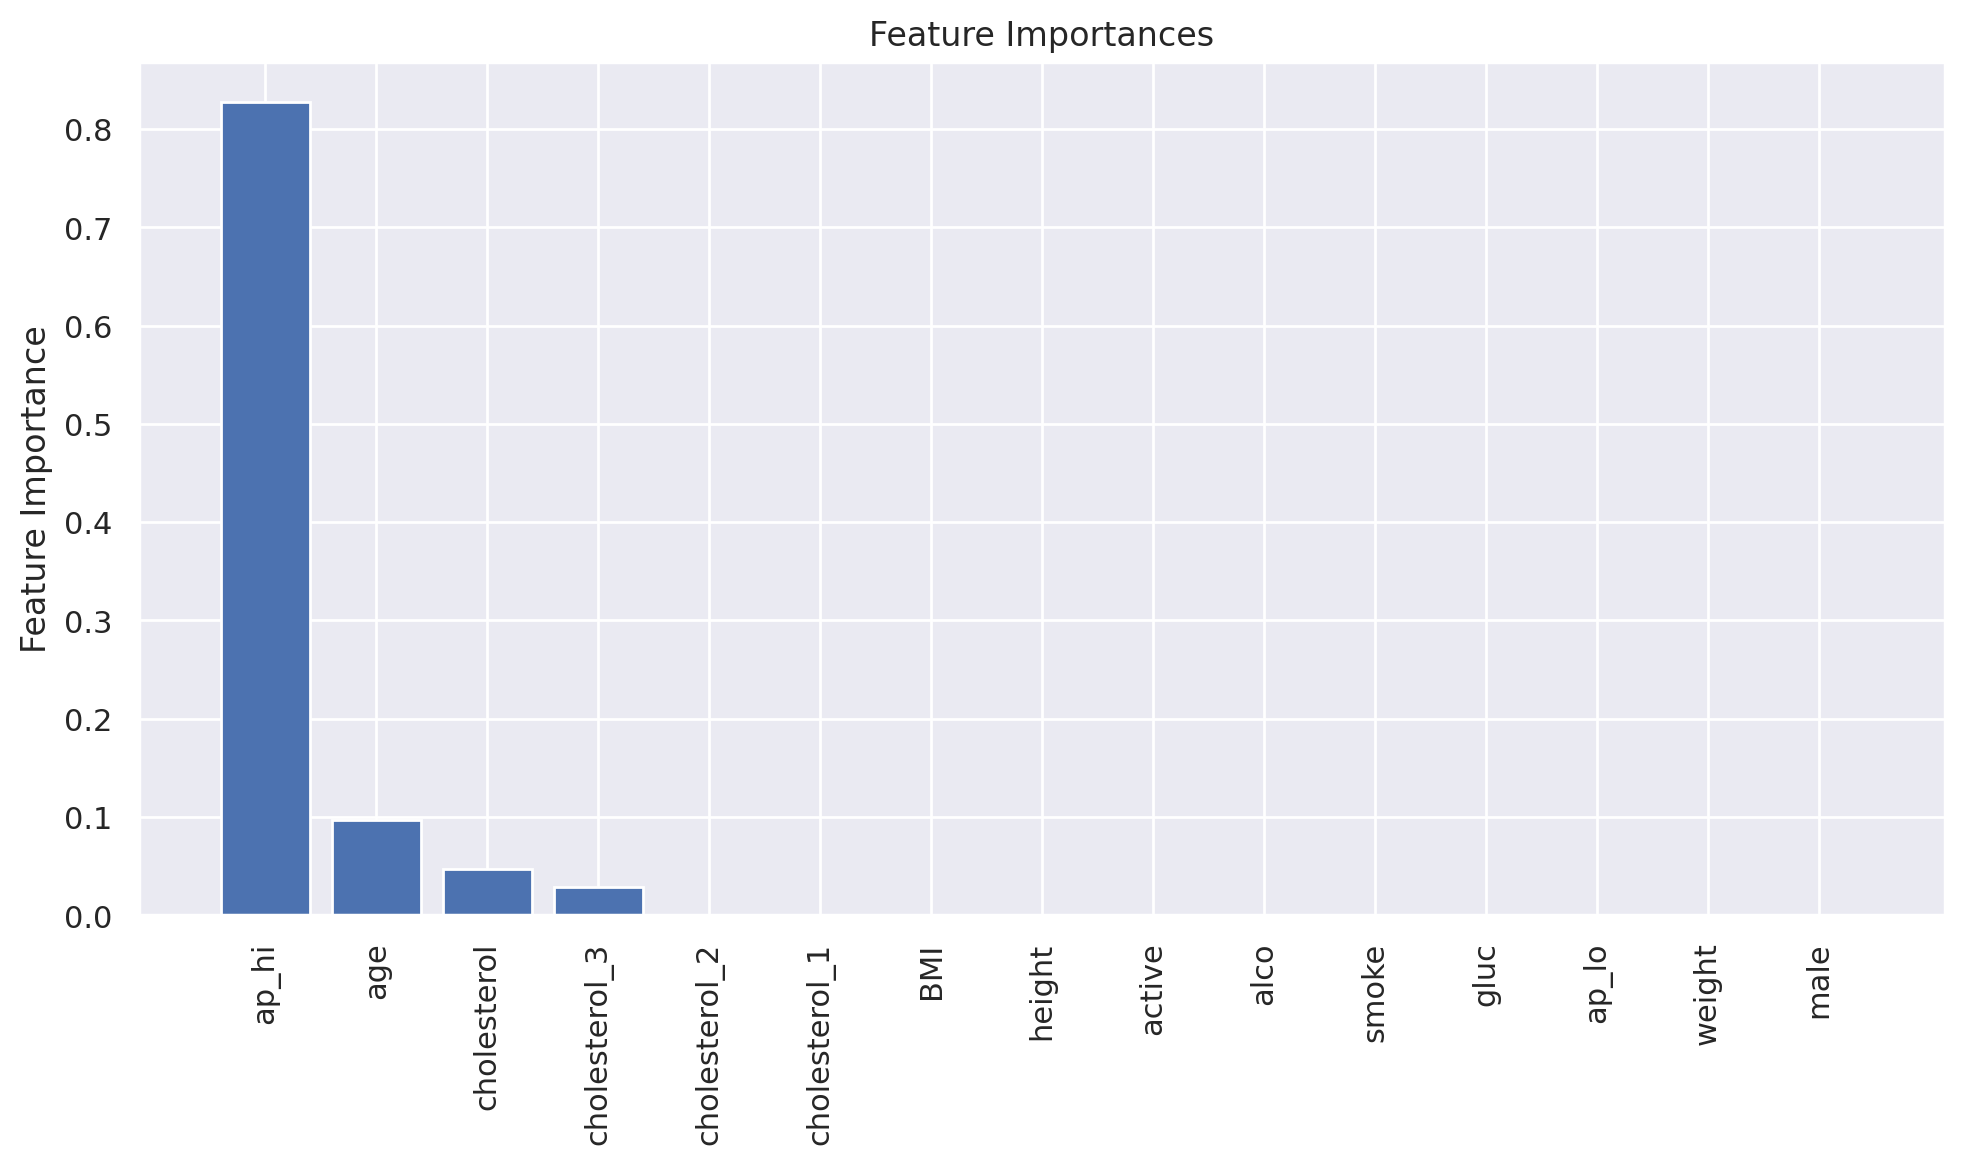

In [ ]:
importances = decision_tree3.feature_importances_
indices = importances.argsort()[::-1]

feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.ylabel("Feature Importance")
plt.tight_layout()


In [ ]:
df2

,age,male,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,height_m,BMI,cholesterol_1,cholesterol_2,cholesterol_3,glucose_cholesterol_1_interaction,glucose_cholesterol_2_interaction,glucose_cholesterol_3_interaction,bmi_physical_activity_interaction,alco_smoke_interaction
id,,,,,,,,,,,,,,,,,,,,,
0,50.0,1,168,62.0,110,80,1,1,0,0,...,1.68,21.967120,1,0,0,1,0,0,21.967120,0
1,55.0,0,156,85.0,140,90,3,1,0,0,...,1.56,34.927679,0,0,1,0,0,1,34.927679,0
2,51.0,0,165,64.0,130,70,3,1,0,0,...,1.65,23.507805,0,0,1,0,0,1,0.000000,0
3,48.0,1,169,82.0,150,100,1,1,0,0,...,1.69,28.710479,1,0,0,1,0,0,28.710479,0
4,47.0,0,156,56.0,100,60,1,1,0,0,...,1.56,23.011177,1,0,0,1,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,52.0,1,168,76.0,120,80,1,1,1,0,...,1.68,26.927438,1,0,0,1,0,0,26.927438,0
99995,61.0,0,158,126.0,140,90,2,2,0,0,...,1.58,50.472681,0,1,0,0,2,0,50.472681,0
99996,52.0,1,183,105.0,180,90,3,1,0,1,...,1.83,31.353579,0,0,1,0,0,1,0.000000,0


In [ ]:
SEL = df2[['ap_hi', 'cardio', 'age', 'BMI', 'cholesterol', 'smoke', 'alco_smoke_interaction', 'glucose_cholesterol_3_interaction', 'bmi_physical_activity_interaction']]

In [ ]:
max_abs = df['ap_hi'].abs().max()
SEL ['ap_hi_normalized'] = SEL ['ap_hi'] / max_abs
SEL  = SEL .drop(columns = ['ap_hi'])

<ipython-input-220-ed6868e444dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SEL ['ap_hi_normalized'] = SEL ['ap_hi'] / max_abs


In [ ]:
X = SEL .drop(columns=['cardio'])
y = SEL ['cardio']

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)
decision_tree4 = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=17)
decision_tree4.fit(X_train, y_train)
ac4 = decision_tree4.score(X_holdout, y_holdout)
ac4

0.7306666666666667

In [ ]:
base_tree = decision_tree4
bagging_classifier = BaggingClassifier(base_estimator=base_tree, n_estimators=10, random_state=17)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)
bagging_classifier.fit(X_train, y_train)
bagging_accuracy = bagging_classifier.score(X_holdout, y_holdout)
print("Accuracy with Bagging:", bagging_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy with Bagging: 0.730904761904762


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_test_accuracy = rf_model.score(X_holdout, y_holdout)
print("Random Forest Test Accuracy:", rf_test_accuracy)

Random Forest Test Accuracy: 0.7264285714285714


In [ ]:
param_grid = {
    'n_estimators': [5, 10, 15],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_rf_model = grid_search.best_estimator_
test_accuracy = best_rf_model.score(X_holdout, y_holdout)
print("Test Accuracy (Best Model):", test_accuracy)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 15}
Test Accuracy (Best Model): 0.73


In [ ]:
adaboost_clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
adaboost_clf.fit(X_train, y_train)

gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)


xgb_boost = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_boost.fit(X_train, y_train)


adaboost_pred = adaboost_clf.predict(X_holdout)
gb_pred = gb_clf.predict(X_holdout)
xgb_boost_pred = xgb_boost.predict(X_holdout)

adaboost_accuracy = accuracy_score(y_holdout, adaboost_pred)
gb_accuracy = accuracy_score(y_holdout, gb_pred)
xgb_boost_accuracy = accuracy_score(y_holdout, xgb_boost_pred)

print("AdaBoost Accuracy:", adaboost_accuracy)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("XGBoost Accuracy:", xgb_boost_accuracy)

AdaBoost Accuracy: 0.7278571428571429
Gradient Boosting Accuracy: 0.7339523809523809
XGBoost Accuracy: 0.7332857142857143


In [ ]:
soft_voting_classifier = VotingClassifier(estimators=[
    ('bagging', bagging_classifier),
    ('rf', best_rf_model),
], voting='soft')

soft_voting_classifier.fit(X_train, y_train)

soft_voting_accuracy = soft_voting_classifier.score(X_holdout, y_holdout)
print("Soft Voting Accuracy:", soft_voting_accuracy)

hard_voting_classifier = VotingClassifier(estimators=[
    ('bagging', bagging_classifier),
    ('rf', best_rf_model),
], voting='hard')

hard_voting_classifier.fit(X_train, y_train)

hard_voting_accuracy = hard_voting_classifier.score(X_holdout, y_holdout)
print("Hard Voting Accuracy:", hard_voting_accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Soft Voting Accuracy: 0.7323333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Hard Voting Accuracy: 0.7311428571428571


In [ ]:
# Ensemble learning with hard voting for Set 1
voting_clf_set1_hard = VotingClassifier(estimators=[('AdaBoost', adaboost_clf),
                                                    ('GradientBoost', gb_clf),
                                                    ('XGBoost', xgb_boost)], voting='hard')
voting_clf_set1_hard.fit(X_train, y_train)
voting_pred_set1_hard = voting_clf_set1_hard.predict(X_holdout)
voting_accuracy_set1_hard = accuracy_score(y_holdout, voting_pred_set1_hard)


# Ensemble learning with soft voting for Set 1
voting_clf_set1_soft = VotingClassifier(estimators=[('AdaBoost', adaboost_clf),
                                                    ('GradientBoost', gb_clf),
                                                    ('XGBoost', xgb_boost)], voting='soft')
voting_clf_set1_soft.fit(X_train, y_train)
voting_pred_set1_soft = voting_clf_set1_soft.predict(X_holdout)
voting_accuracy_set1_soft = accuracy_score(y_holdout, voting_pred_set1_soft)

In [ ]:
# Ensemble learning with hard voting for Set 2
voting_clf_set2_hard = VotingClassifier(estimators=[('bagging', bagging_classifier),
                                                    ('RandomForest', best_rf_model)], voting='hard')
voting_clf_set2_hard.fit(X_train, y_train)
voting_pred_set2_hard = voting_clf_set2_hard.predict(X_holdout)
voting_accuracy_set2_hard = accuracy_score(y_holdout, voting_pred_set2_hard)

# Ensemble learning with soft voting for Set 2
voting_clf_set2_soft = VotingClassifier(estimators=[('bagging', bagging_classifier),
                                                    ('RandomForest', best_rf_model)], voting='soft')
voting_clf_set2_soft.fit(X_train, y_train)
voting_pred_set2_soft = voting_clf_set2_soft.predict(X_holdout)
voting_accuracy_set2_soft = accuracy_score(y_holdout, voting_pred_set2_soft)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
print("Set 1 - Hard Voting Accuracy:", voting_accuracy_set1_hard)
print("Set 1 - Soft Voting Accuracy:", voting_accuracy_set1_soft)
print("Set 2 - Hard Voting Accuracy:", voting_accuracy_set2_hard)
print("Set 2 - Soft Voting Accuracy:", voting_accuracy_set2_soft)

Set 1 - Hard Voting Accuracy: 0.7337619047619047
Set 1 - Soft Voting Accuracy: 0.7331904761904762
Set 2 - Hard Voting Accuracy: 0.7311428571428571
Set 2 - Soft Voting Accuracy: 0.7323333333333333


In [ ]:
voting_clf_hard = VotingClassifier(estimators=[('Set1_Hard', voting_clf_set1_hard),
                                               ('Set2_Hard', voting_clf_set2_hard)], voting='hard')
voting_clf_hard.fit(X_train, y_train)
voting_pred_hard = voting_clf_hard.predict(X_holdout)
voting_accuracy_hard = accuracy_score(y_holdout, voting_pred_hard)

voting_clf_soft = VotingClassifier(estimators=[('Set1_Soft', voting_clf_set1_soft),
                                               ('Set2_Soft', voting_clf_set2_soft)], voting='soft')
voting_clf_soft.fit(X_train, y_train)
voting_pred_soft = voting_clf_soft.predict(X_holdout)
voting_accuracy_soft = accuracy_score(y_holdout, voting_pred_soft)

print("Hard Voting on Both Sets Accuracy:", voting_accuracy_hard)
print("Soft Voting on Both Sets Accuracy:", voting_accuracy_soft)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Hard Voting on Both Sets Accuracy: 0.7325238095238096
Soft Voting on Both Sets Accuracy: 0.7333809523809524


Here in this problems I have done a lot of feature engineering.



Firstly, I have checked correlation between all our features and the target variable. I have used encoding on the categorical features that were highly correlated because i believe having binary features individually would help the model understand the underlying features better.



I have then visualized few heatmaps and based on how correlated independent features are I have created interaction terms within them.



Now, I have created 3 subdataframes

1) Just the independent features
2) Just the interaction terms
3) Both Independent and Interaction Terms



I then normalized the numerical features based on their distributions and tried to fit my optimal decison tree model on all of these datasets but I wasn't satisfied with their accuarcy.


So i plotted feature importance maps and figured out which features were contributing more to the model so I have manully re engineered a new data frame with selective features called **SEL** that gave better accuracy of **73.06** which beat both the baseline models.

I also use ensemble learning here

1) Firstly I have developed an ensemble model consisting of 3 boosting models which gave accuracys


*   Gradient Boosting Accuracy: 0.7339523809523809
*   XGBoost Accuracy: 0.7332857142857143
*   AdaBoost Accuracy: 0.7278571428571429


2) Secondly I ran a bagging classifier with multiplr decison trees and also a random forest model which was optimized with hyper parameter tuning and combined they both gave an accuracy of

*   Soft Voting Accuracy: 0.7323333333333333
*   Hard Voting Accuracy: 0.7311428571428571

3) I used both hard voting and soft voting to manually check which method was best as there was no theroretical explaantion on which is better it depends on the situation.

Then I created 2 sets of ensemble learning first set has boosting and the second set has bagging and random forest classifiers

*   Set 1 - Soft Voting Accuracy: 0.7331904761904762
*   Set 1 - Hard Voting Accuracy: 0.7337619047619047
*   Set 2 - Hard Voting Accuracy: 0.7311428571428571
*   Set 2 - Soft Voting Accuracy: 0.7323333333333333


And now on these both sets i have used hard voting on both hard sets and soft voting on both sets and got the accuracy of

*   Hard Voting on Both Sets Accuracy: 0.7325238095238096
*   Soft Voting on Both Sets Accuracy: 0.7333809523809524


NOW TO CONCLUDE AFTER CONSIDERING ALL THE MODELS THE MODEL WITH THE HIGHEST ACCURACY WAS THE GRADIENT BOOSTING MODEL. IT PERFORMED SLIGHTLY BETTER THAN ALL 3 BOOSTING COMBINED AND ALOS BETTER THAN BAGGING CLASSIFIER.

What i noticed is XGB is robust here to this data and performs better than anymodel.

Though i beleve the backdrop for each model was overfitting and I plan on working on it more to improve the accuracy.

# My concept on how to approach a real world data set:

Well, First of all to  tackle the challenge of developing a disease susceptibility predictor:

1) I would start with trying to understand the nature of the data. Which involves considering factors such as the complexity of the relationship between features and the target variable, the presence of noise or outliers, and the quality of the data sources. If the data is inherently complex or noisy, ensemble methods may be more effective in capturing these nuances compared to simple baseline models. Additionally, we should also check if the dataset size is sufficient for training robust models or if acquiring more data is necessary to improve model generalization and after assesing the nature of data which basically means to entail exploratory data analysis (EDA) to comprehend the dataset's intricacies which involves scrutinizing feature distributions, detecting missing values, and assessing outliers. Subsequently, feature engineering becomes paramount, wherein relevant features such as demographic information and known risk factors are extracted and transformed appropriately. Categorical variables would be encoded suitably to facilitate model training.

2) Secondly, I would initiate the model validation would involve splitting the dataset into training and testing sets, with cross-validation employed to ensure the robustness of the chosen algorithms.

3) Now, after considering the interpretability of results, if it requires a simple basline models such as logistic regression, linear regression and simple Decison Tree which could serve as a fundamental model for any classification model, we would pretty much follow a standard procedure that involves

             Data Preprocessing

1.   Handle missing values: can impute or Remove missing values as necessary.

2.   Encode categorical variables: convrting categorical variables into numerical format using techniques like one-hot encoding.

              Feature Selection/ Engineering:

1.   Now we should select relevant features based on our knowledge of the problem and after performing exploratory data analysis.


2. Engineering new features if needed, such as interaction terms or transformations.

            Model Training:

1.   This can be done with selecting the appropriate baseline model and training the model on the training data.

              Model Evaluation:

1.   Evaluating the model's performance on the validation/ holdout data or test set using appropriate metrics (accuracy for classification, mean squared error for regression in general).
2. We can also exclusively comapre the baseline model's performance against a random predictor to assess its effectiveness.

 **And now when we come across few situations such as:**

1.   High Variance Models
2.   Noisy Data
3.   Complex Relationships
4.   Huge feature Space(Where the baseline model usually tends to overfit)

We can go with ensemble learning concept in machine learning which involves
initially picking a baseline model such as a decision tree and then it is to be used within the ensemble

1.   (Bagging) Training multiple base models on different subsets of the training data
2.   (Boosting) Iteratively improving weak learners

While we follow the standard procedure in this situation as well we can improve the performance of the models by using hyperparameter tuning using **GridSearch** where we can significantly enhance the performance of ensemble methods by systematically searching through a specified hyperparameter space to find the combination that yields the best results and specifically for ensemble methods, such as bagging and boosting, there are hyperparameters that govern the behavior of the individual base models and the ensemble as a whole also during the process of evaluation we can add few additional steps for ensemble learning like row sampling , feature sampling with replacemnt and Computing ensemble specific metrics like out-of-bag (OOB) error for bagging or learning curves for boosting and also analyzing feature importance or contribution of base models in the ensemble.

And byintegrating these theoretical considerations I believe, we can design a robust disease susceptibility predictor that effectively leverages machine learning principles to address the complexities of the problem at hand.


**My personal favourite is Random Forest**

Because of

1) How well it performs even in high-dimensional feature spaces, making them suitable for datasets with a large number of features because I'd assume in reak world scenario we would be given multiple number of contextual features and asked to give a model that captures the performance jointly.

2) Besides that Random forests are also noncparametric models, meaning they make minimal assumptions about the underlying distribution of the data. This would give the flexibility to capture complex relationships between features and the target variable without imposing rigid assumptions.

3) Last but not least on how Random forests are scaleable and can handle missing data effectively by using the available features to make predictions.



---


### Q3.2 (5pt)
Briefly describe
1.  some potential shortcomings of your training process from the disease
susceptibility predictor scenario above that may result in your algorithm having different accuracy on
different populations, and

2. how you may modify your procedure to address these shortcomings.


Clearly-written and well-thought-out answers addressing (1) and (2) (as described in the
problem). Two short paragraphs or one medium paragraph suffice.


Well as it is a real time data we never know how the model may work by theoretical assumptions ao when we first run the model we might face few issues such as having tarining data that is not represented very well which could lead to different accuracies on different populations. because if the training data primarily only consists of samples from a specific demographic or geographical region, the resulting algorithm may not generalize well to other populations with different characteristics and miss a lot of other patterns to recognize rest of the population very well.

To overcome this we can try and collect data from a wide range of sources and populations, including diverse demographics, geographic locations, and socioeconomic backgrounds. Additionally, employing techniques such as stratified sampling or oversampling of underrepresented groups can help balance the dataset and ensure adequate representation of all relevant populations.moreover, integrating expertise from the relevant field and conducting comprehensive exploratory data analysis can assist in recognizing and rectifying biases within the dataset. This approach fosters the development of a more resilient and equitable disease susceptibility predictor, ensuring uniform performance across various demographic groups.